# Introdução

Esse projeto tem como objetivo analisar uma base de dados cinematográfica a partir do desafio proposto pela Indicium. A PProductions, um estúdio de Hollywood, busca identificar qual tipo de filme deve ser priorizado em seu próximo projeto. Para apoiar essa decisão, realizamos uma análise exploratória detalhada, levantamos hipóteses sobre fatores associados ao desempenho dos filmes e avaliamos a possibilidade de construção de modelos preditivos.

Antes da exploração, foi realizado um tratamento dos dados e também a incorporação de informações externas, incluindo a variável de orçamento (Budget), considerada fundamental para alcançar os objetivos do desfio. Esse enriquecimento permitiu conduzir uma análise mais robusta e alinhada às necessidades estratégicas da PProductions.

A estrutura do trabalho segue três etapas principais:

1) Análise exploratória (EDA): compreensão das variáveis, identificação de padrões e geração de hipóteses.

2) Questões do desafio: recomendação de filme para um público desconhecido, fatores relacionados ao faturamento, insights a partir da coluna Overview e discussão sobre sua utilidade para inferir gênero.

3) Modelagem preditiva: proposta de abordagem para previsão da nota do IMDB, seleção de variáveis, justificativa do modelo e avaliação de métricas.

Nosso objetivo foi alinhar a exploração estatística e gráfica a implicações práticas de negócio, entregando recomendações que possam efetivamente apoiar as decisões estratégicas do estúdio.

In [548]:
# Fazendo os imports das bibliotecas necessárias

import os
import re
import time
from copy import deepcopy
from urllib.parse import quote

import numpy as np
import pandas as pd
import requests
import joblib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from tqdm.notebook import tqdm
from wordcloud import WordCloud

from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_validate,
    GridSearchCV,
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats



In [549]:
# Carregando o arquivo
df = pd.read_csv('../data/desafio_indicium_imdb.csv')
df.head()

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


In [550]:
# Checando se há linhas iguais
df.duplicated().any()

False

In [551]:
# Checando como as colunas estão
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB


# Tratamento dos dados

In [552]:
# TRATAMENTO NECESSÁRIO PARA ALGUMAS COLUNAS
# Runtime como inteiro
df['Runtime'] = df['Runtime'].astype(str).str.replace(" min","")
df['Runtime'] = pd.to_numeric(df['Runtime'], errors='coerce')  # converte para int, NaN se der problema


# Tratamento do faturamento:
# Remover as vírgulas usando .str.replace()
df['Gross'] = df['Gross'].str.replace(',', '')

# O segundo passo é converter a coluna para um tipo numérico
# Usamos pd.to_numeric com 'errors=coerce' para forçar a conversão.
# Qualquer valor que não puder ser convertido (como os valores ausentes 'NaN')
# será transformado em NaN numérico.
df['Gross'] = pd.to_numeric(df['Gross'], errors='coerce')


# Gross em milhões
df['Gross_Million'] = df['Gross'] / 1e6

# Certificado ausente como 'Not Rated'
df['Certificate'] = df['Certificate'].fillna('Not Rated')

# Ano como inteiro
df['Released_Year'] = pd.to_numeric(df['Released_Year'], errors='coerce')  # valores inválidos viram NaN
df['Ano'] = df['Released_Year'].astype('Int64')  # mantém NaNs

# Criar coluna Primary_Genre com o primeiro gênero listado
df['Primary_Genre'] = df['Genre'].str.split(',').str[0]

# Apagando uma coluna desnecessária
df = df.drop('Unnamed: 0', axis=1)

Convertemos a coluna Runtime para inteiro, removendo o sufixo "min" e transformando valores inválidos em NaN. Isso permite usar a duração dos filmes em análises numéricas.

Tratamos a coluna Gross, primeiro removendo as vírgulas e depois convertendo para número. Em seguida, criamos a variável Gross_Million para representar o faturamento em milhões, facilitando a leitura dos gráficos e reduzindo distorções de escala.

Preenchemos os valores ausentes de Certificate com 'Not Rated', evitando que fiquem nulos durante as análises.

Convertemos a coluna Released_Year para inteiro, criando também a variável Ano para preservar eventuais NaN. Isso facilita análises temporais, como tendências de notas e faturamento ao longo do tempo.

Criamos a coluna Primary_Genre, considerando apenas o primeiro gênero listado. A coluna original contém múltiplos gêneros, o que dificulta analisar a relação de gênero com faturamento e notas do IMDB.

Por fim, removemos a coluna Unnamed: 0, criada automaticamente na importação do CSV, pois não tem utilidade para a análise.

Adicionei a coluna Orçamento para análise mais robusta dos filmes. Puxei os dados dela através da API do TMDB que é uma API gratuita para base de filmes. Tentei puxar dados faltantes do Gross, Meta_score e Certificate através da API da OMDB, que também é uma API gratuita para base de filmes. Inseri os dados que obtive.

In [553]:
# Definir a chave de acesso da API do TMDb que será usada para buscar os orçamentos

os.environ["TMDB_API_KEY"] = "eac44b2b01d4ec9d9bb987d96d5dcdc4"

In [554]:
'''
# Pega a chave da API
TMDB_API_KEY = os.getenv("TMDB_API_KEY")

def limpar_titulo(t):
    if not isinstance(t, str): return ""
    t = re.sub(r"\s+", " ", t).strip()
    t = re.sub(r"\(.*?\)", "", t).strip()  # remove subtítulos entre parênteses
    return t

def tmdb_search_id(title, year=None):
    """Busca ID do filme no TMDb"""
    url = "https://api.themoviedb.org/3/search/movie"
    params = {"api_key": TMDB_API_KEY, "query": title, "page": 1}
    if year and str(year).isdigit():
        params["year"] = int(year)
    r = requests.get(url, params=params)
    if r.status_code != 200:
        return None
    results = r.json().get("results", [])
    if not results:
        return None
    return results[0].get("id")

def tmdb_get_budget(movie_id):
    """Pega orçamento (budget) em USD no TMDb"""
    url = f"https://api.themoviedb.org/3/movie/{movie_id}"
    params = {"api_key": TMDB_API_KEY}
    r = requests.get(url, params=params)
    if r.status_code != 200:
        return 0
    data = r.json()
    return data.get("budget", 0)  # já vem em USD

def wikidata_budget(title):
    """Fallback: tenta buscar orçamento na Wikidata"""
    query = f"""
    SELECT ?amount ?currencyLabel WHERE {{
      ?film rdfs:label "{title}"@en.
      ?film p:P2130 ?statement.
      ?statement ps:P2130 ?amountNode.
      ?amountNode wikibase:quantityAmount ?amount;
                  wikibase:quantityUnit ?currency.
      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
    }} LIMIT 1
    """
    url = "https://query.wikidata.org/sparql"
    headers = {"Accept": "application/sparql-results+json"}
    r = requests.get(url, params={"query": query}, headers=headers)
    if r.status_code != 200:
        return None, None
    data = r.json()
    bindings = data["results"]["bindings"]
    if not bindings:
        return None, None
    amount = float(bindings[0]["amount"]["value"])
    currency = bindings[0]["currencyLabel"]["value"]
    return amount, currency
'''

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Technook\AppData\Local\Temp\ipykernel_20048\1933806081.py:1: SyntaxWarning: invalid escape sequence '\s'
  '''


'\n# Pega a chave da API\nTMDB_API_KEY = os.getenv("TMDB_API_KEY")\n\ndef limpar_titulo(t):\n    if not isinstance(t, str): return ""\n    t = re.sub(r"\\s+", " ", t).strip()\n    t = re.sub(r"\\(.*?\\)", "", t).strip()  # remove subtítulos entre parênteses\n    return t\n\ndef tmdb_search_id(title, year=None):\n    """Busca ID do filme no TMDb"""\n    url = "https://api.themoviedb.org/3/search/movie"\n    params = {"api_key": TMDB_API_KEY, "query": title, "page": 1}\n    if year and str(year).isdigit():\n        params["year"] = int(year)\n    r = requests.get(url, params=params)\n    if r.status_code != 200:\n        return None\n    results = r.json().get("results", [])\n    if not results:\n        return None\n    return results[0].get("id")\n\ndef tmdb_get_budget(movie_id):\n    """Pega orçamento (budget) em USD no TMDb"""\n    url = f"https://api.themoviedb.org/3/movie/{movie_id}"\n    params = {"api_key": TMDB_API_KEY}\n    r = requests.get(url, params=params)\n    if r.status_

In [555]:
'''
def buscar_orcamentos(df):
    resultados = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        titulo = limpar_titulo(row["Series_Title"])
        ano = row["Released_Year"]

        # Primeiro tenta no TMDb
        movie_id = tmdb_search_id(titulo, ano)
        budget_tmdb = 0
        if movie_id:
            budget_tmdb = tmdb_get_budget(movie_id)
            time.sleep(0.25)  # evita bloqueio da API

        # Se não achou no TMDb, tenta Wikidata
        budget_wiki, currency = (None, None)
        if not budget_tmdb:
            budget_wiki, currency = wikidata_budget(titulo)
            time.sleep(0.5)

        resultados.append({
            "Series_Title": titulo,
            "Released_Year": ano,
            "Budget_USD_TMDb": budget_tmdb if budget_tmdb else None,
            "Budget_Wikidata": budget_wiki,
            "Currency_Wikidata": currency
        })

    return pd.DataFrame(resultados)
'''

'\ndef buscar_orcamentos(df):\n    resultados = []\n    for _, row in tqdm(df.iterrows(), total=len(df)):\n        titulo = limpar_titulo(row["Series_Title"])\n        ano = row["Released_Year"]\n\n        # Primeiro tenta no TMDb\n        movie_id = tmdb_search_id(titulo, ano)\n        budget_tmdb = 0\n        if movie_id:\n            budget_tmdb = tmdb_get_budget(movie_id)\n            time.sleep(0.25)  # evita bloqueio da API\n\n        # Se não achou no TMDb, tenta Wikidata\n        budget_wiki, currency = (None, None)\n        if not budget_tmdb:\n            budget_wiki, currency = wikidata_budget(titulo)\n            time.sleep(0.5)\n\n        resultados.append({\n            "Series_Title": titulo,\n            "Released_Year": ano,\n            "Budget_USD_TMDb": budget_tmdb if budget_tmdb else None,\n            "Budget_Wikidata": budget_wiki,\n            "Currency_Wikidata": currency\n        })\n\n    return pd.DataFrame(resultados)\n'

In [556]:
'''
# Carregando os orçamentos obtidos
df_orcamentos = buscar_orcamentos(df)

# Salvar resultado em CSV
df_orcamentos.to_csv("../data/orcamentos_filmes.csv", index=False)

df_orcamentos.head()
'''

'\n# Carregando os orçamentos obtidos\ndf_orcamentos = buscar_orcamentos(df)\n\n# Salvar resultado em CSV\ndf_orcamentos.to_csv("../data/orcamentos_filmes.csv", index=False)\n\ndf_orcamentos.head()\n'

In [557]:

# Carregar CSV de budgets gerado pela função buscar_orcamentos
df_budget = pd.read_csv("../data/orcamentos_filmes.csv")

# Converter Budget para número (caso tenha texto ou ano indevido)
df_budget["Budget_USD_TMDb"] = pd.to_numeric(df_budget["Budget_USD_TMDb"], errors="coerce")

# Criar dicionário {titulo: budget}
budget_dict = df_budget.set_index("Series_Title")["Budget_USD_TMDb"].to_dict()

# Adicionar coluna Budget no df original sem aumentar linhas
df["Budget"] = df["Series_Title"].map(budget_dict)

# Aplicar corte mínimo de 2025 (filmes com valor menor viram NaN)
df["Budget"] = df["Budget"].apply(lambda x: x if pd.notnull(x) and x >= 2025 else np.nan)

print("✅ Coluna Budget adicionada ao df! Total de linhas permanece:", len(df))
df[["Series_Title", "Budget"]].head()


✅ Coluna Budget adicionada ao df! Total de linhas permanece: 999


,Series_Title,Budget
0,The Godfather,6000000.0
1,The Dark Knight,185000000.0
2,The Godfather: Part II,13000000.0
3,12 Angry Men,397751.0
4,The Lord of the Rings: The Return of the King,94000000.0


In [558]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   999 non-null    object 
 1   Released_Year  998 non-null    float64
 2   Certificate    999 non-null    object 
 3   Runtime        999 non-null    int64  
 4   Genre          999 non-null    object 
 5   IMDB_Rating    999 non-null    float64
 6   Overview       999 non-null    object 
 7   Meta_score     842 non-null    float64
 8   Director       999 non-null    object 
 9   Star1          999 non-null    object 
 10  Star2          999 non-null    object 
 11  Star3          999 non-null    object 
 12  Star4          999 non-null    object 
 13  No_of_Votes    999 non-null    int64  
 14  Gross          830 non-null    float64
 15  Gross_Million  830 non-null    float64
 16  Ano            998 non-null    Int64  
 17  Primary_Genre  999 non-null    object 
 18  Budget    

In [559]:
# Carregando chave API do OMDB
os.environ["OMDB_API_KEY"] = "f32b0cf9"

In [560]:

# Atualizar meta_score no df sem criar linhas novas

OMDB_API_KEY = os.getenv("OMDB_API_KEY")

def buscar_meta_score(titulo, ano=None):
    """Busca o Metascore de um filme na OMDb"""
    url = f"http://www.omdbapi.com/?t={titulo}&apikey={OMDB_API_KEY}"
    if ano and str(ano).isdigit():
        url += f"&y={ano}"
    r = requests.get(url)
    if r.status_code != 200:
        return None
    data = r.json()
    if data.get("Response") == "True" and data.get("Metascore") not in [None, "N/A"]:
        return int(data["Metascore"])
    return None

# Pega só os filmes sem Meta_score
faltantes_meta = df[df["Meta_score"].isna()][["Series_Title", "Released_Year"]]

for idx, row in tqdm(faltantes_meta.iterrows(), total=len(faltantes_meta)):
    score = buscar_meta_score(row["Series_Title"], row["Released_Year"])
    if score is not None:
        df.loc[idx, "Meta_score"] = score

print("✅ Meta_score atualizado! Total de linhas:", len(df))


  0%|          | 0/157 [00:00<?, ?it/s]

✅ Meta_score atualizado! Total de linhas: 999


In [561]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   999 non-null    object 
 1   Released_Year  998 non-null    float64
 2   Certificate    999 non-null    object 
 3   Runtime        999 non-null    int64  
 4   Genre          999 non-null    object 
 5   IMDB_Rating    999 non-null    float64
 6   Overview       999 non-null    object 
 7   Meta_score     863 non-null    float64
 8   Director       999 non-null    object 
 9   Star1          999 non-null    object 
 10  Star2          999 non-null    object 
 11  Star3          999 non-null    object 
 12  Star4          999 non-null    object 
 13  No_of_Votes    999 non-null    int64  
 14  Gross          830 non-null    float64
 15  Gross_Million  830 non-null    float64
 16  Ano            998 non-null    Int64  
 17  Primary_Genre  999 non-null    object 
 18  Budget    

In [562]:

# Atualizar Gross no df sem criar linhas novas

def buscar_gross_domestico(titulo, ano=None):
    """Busca o faturamento doméstico (BoxOffice) de um filme na OMDb"""
    url = f"http://www.omdbapi.com/?t={titulo}&apikey={OMDB_API_KEY}"
    if ano and str(ano).isdigit():
        url += f"&y={ano}"
    r = requests.get(url)
    if r.status_code != 200:
        return None
    data = r.json()
    if data.get("Response") == "True" and data.get("BoxOffice") not in [None, "N/A"]:
        valor = data["BoxOffice"].replace("$", "").replace(",", "")
        try:
            return int(valor)
        except:
            return None
    return None

# Pega só os filmes sem Gross
faltantes_gross = df[df["Gross"].isna()][["Series_Title", "Released_Year"]]

for idx, row in tqdm(faltantes_gross.iterrows(), total=len(faltantes_gross)):
    gross = buscar_gross_domestico(row["Series_Title"], row["Released_Year"])
    if gross is not None:
        df.loc[idx, "Gross"] = gross

print("✅ Gross atualizado! Total de linhas:", len(df))


  0%|          | 0/169 [00:00<?, ?it/s]

✅ Gross atualizado! Total de linhas: 999


 Vemos abaixo que para a maioria das colunas temos uma boa quantidade de dados, tendo pelo menos 83% dos dados totais para as colunas originais depois que eu inseri os novos dados. Tratei os nulos do Certificate inserindo 'Not rated' nele, o que é uma boa abordagem para essa categoria. Decidi deixar as linhas com Gross e meta_score nulos como estão, pois descartá-las deixaria o dataset com pouca quantidade de dados para uma EDA mais robusta e porque os nulos não atrapalham a maioria dos gráficos gerados pelas bibliotecas Pandas, Matplotlib e Seaborn. Preferi fazer isso do que inserir valores calculados com base em alguma média porque considero essa inserção muito arriscada para gerar falsos resultados para a EDA, deixando a parte de tratar os nulos com descarte das linhas ou preenchimento apenas para o Machine Learning.

In [563]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   999 non-null    object 
 1   Released_Year  998 non-null    float64
 2   Certificate    999 non-null    object 
 3   Runtime        999 non-null    int64  
 4   Genre          999 non-null    object 
 5   IMDB_Rating    999 non-null    float64
 6   Overview       999 non-null    object 
 7   Meta_score     863 non-null    float64
 8   Director       999 non-null    object 
 9   Star1          999 non-null    object 
 10  Star2          999 non-null    object 
 11  Star3          999 non-null    object 
 12  Star4          999 non-null    object 
 13  No_of_Votes    999 non-null    int64  
 14  Gross          862 non-null    float64
 15  Gross_Million  830 non-null    float64
 16  Ano            998 non-null    Int64  
 17  Primary_Genre  999 non-null    object 
 18  Budget    

In [564]:
df.head(5)

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Gross_Million,Ano,Primary_Genre,Budget
0,The Godfather,1972.0,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0,134.966411,1972,Crime,6000000.0
1,The Dark Knight,2008.0,UA,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0,534.858444,2008,Action,185000000.0
2,The Godfather: Part II,1974.0,A,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0,57.300000,1974,Crime,13000000.0
3,12 Angry Men,1957.0,U,96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0,4.360000,1957,Crime,397751.0
4,The Lord of the Rings: The Return of the King,2003.0,U,201,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377845905.0,377.845905,2003,Action,94000000.0


## (PERGUNTA) a.	Qual filme você recomendaria para uma pessoa que você não conhece?

 Primeira fator fundamental para responder a pergunta é indicar um filme com classificação menos restrita, pois não sei a idade da pessoa que vai assistir. Segunda coisa é priorizar as características. Decidi por priorizar a nota no IMDB (IMDB_Rating), a nota dos críticos (Meta_score) e o número de votos (No_of_Votes). Escolhi este último ao invés do faturamento nos cinemas porque um grande número de votos no IMDB significa que muitas pessoas assistiram e se sentiram motivadas a avaliar o filme. E isso é um forte indicador de que ele foi um sucesso (se as notas também tiverem sido altas). Já o faturamento vai depender do filme ter sido um sucesso nos cinemas e um filme pode ser um sucesso de popularidade, mas não ter tido bom faturamento nos cinemas.

In [565]:
# Filtrar o DataFrame por certificados seguros
certificados_seguros = ['G', 'PG', 'U', 'U/A']
df_recomendacao = df[df['Certificate'].isin(certificados_seguros)].copy()

# Remover valores nulos para evitar erros nos gráficos
df_recomendacao.dropna(subset=['IMDB_Rating', 'Meta_score', 'No_of_Votes'], inplace=True)

# Top 10 por IMDB Rating
top_10_imdb = df_recomendacao.nlargest(10, 'IMDB_Rating').sort_values('IMDB_Rating', ascending=False)

# Top 10 por Meta Score
top_10_meta = df_recomendacao.nlargest(10, 'Meta_score').sort_values('Meta_score', ascending=False)

# Top 10 por Número de Votos
top_10_votos = df_recomendacao.nlargest(10, 'No_of_Votes').sort_values('No_of_Votes', ascending=False)

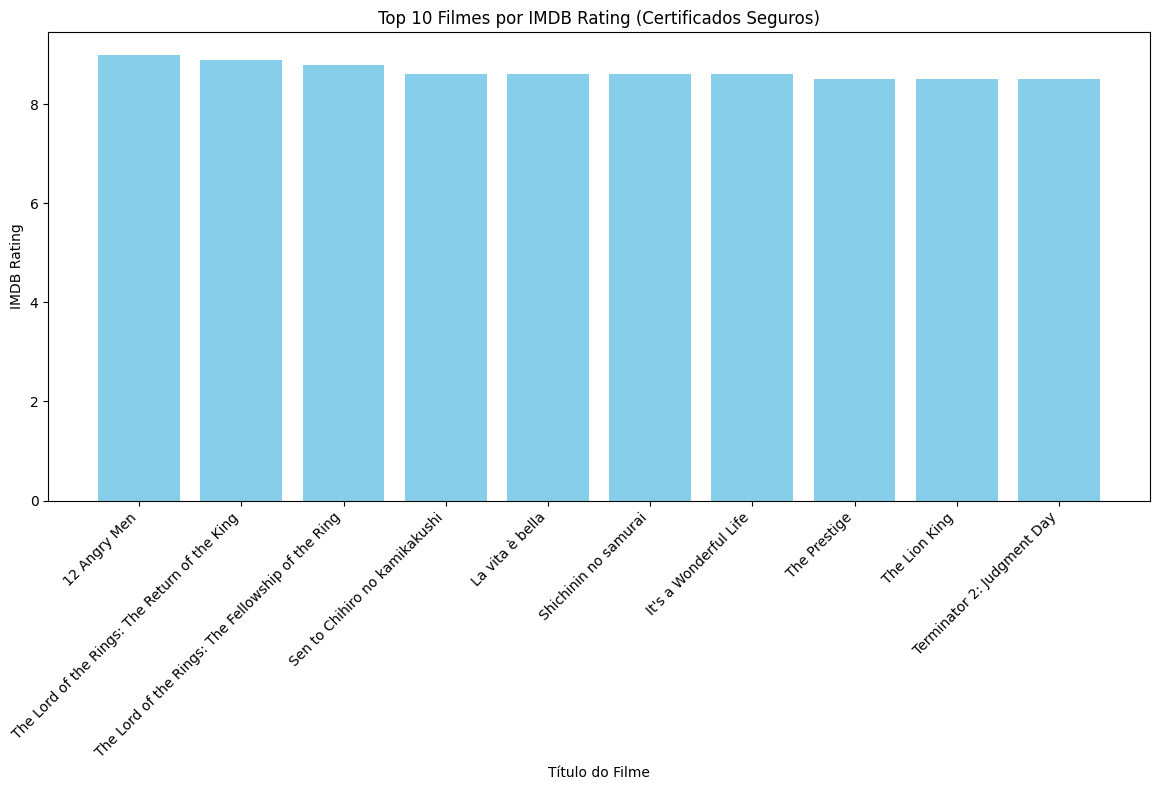

In [566]:
# Gráfico Top 10 IMDB Rating
plt.figure(figsize=(12, 8))
plt.bar(top_10_imdb['Series_Title'], top_10_imdb['IMDB_Rating'], color='skyblue')
plt.title('Top 10 Filmes por IMDB Rating (Certificados Seguros)')
plt.xlabel('Título do Filme')
plt.ylabel('IMDB Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

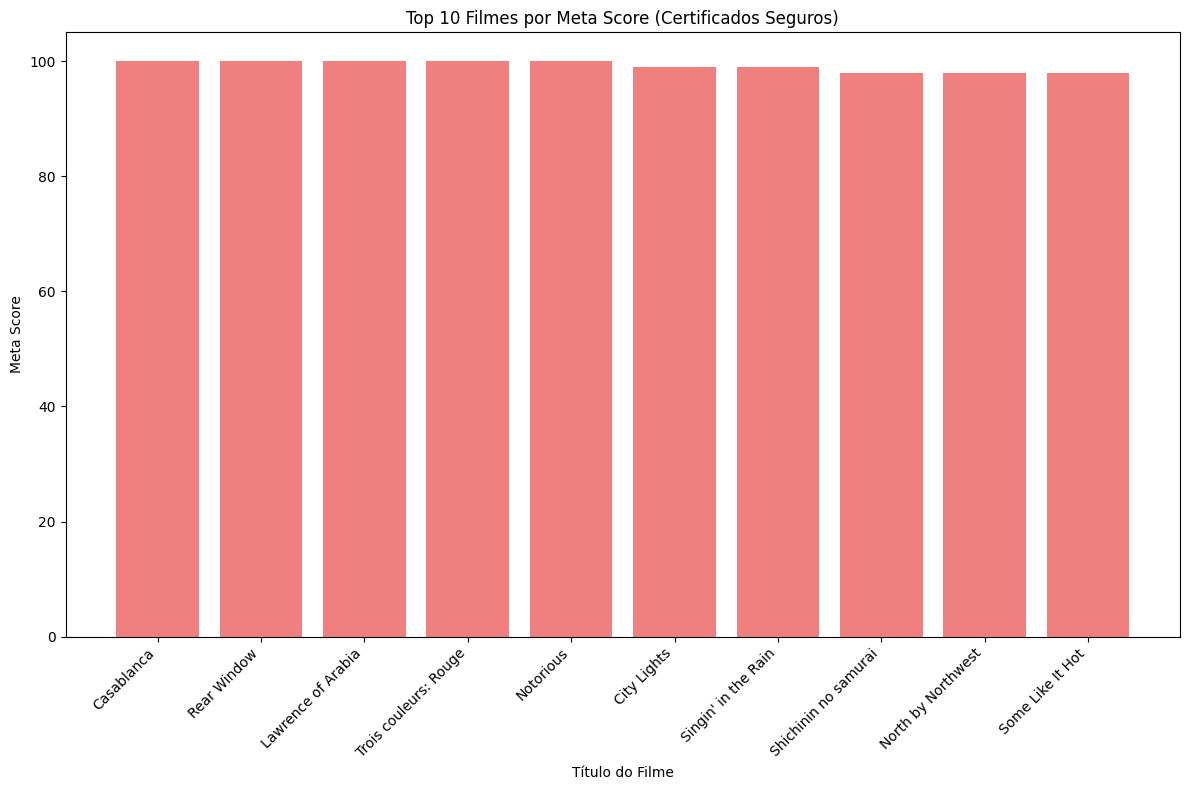

In [567]:
# Gráfico Top 10 Meta Score
plt.figure(figsize=(12, 8))
plt.bar(top_10_meta['Series_Title'], top_10_meta['Meta_score'], color='lightcoral')
plt.title('Top 10 Filmes por Meta Score (Certificados Seguros)')
plt.xlabel('Título do Filme')
plt.ylabel('Meta Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

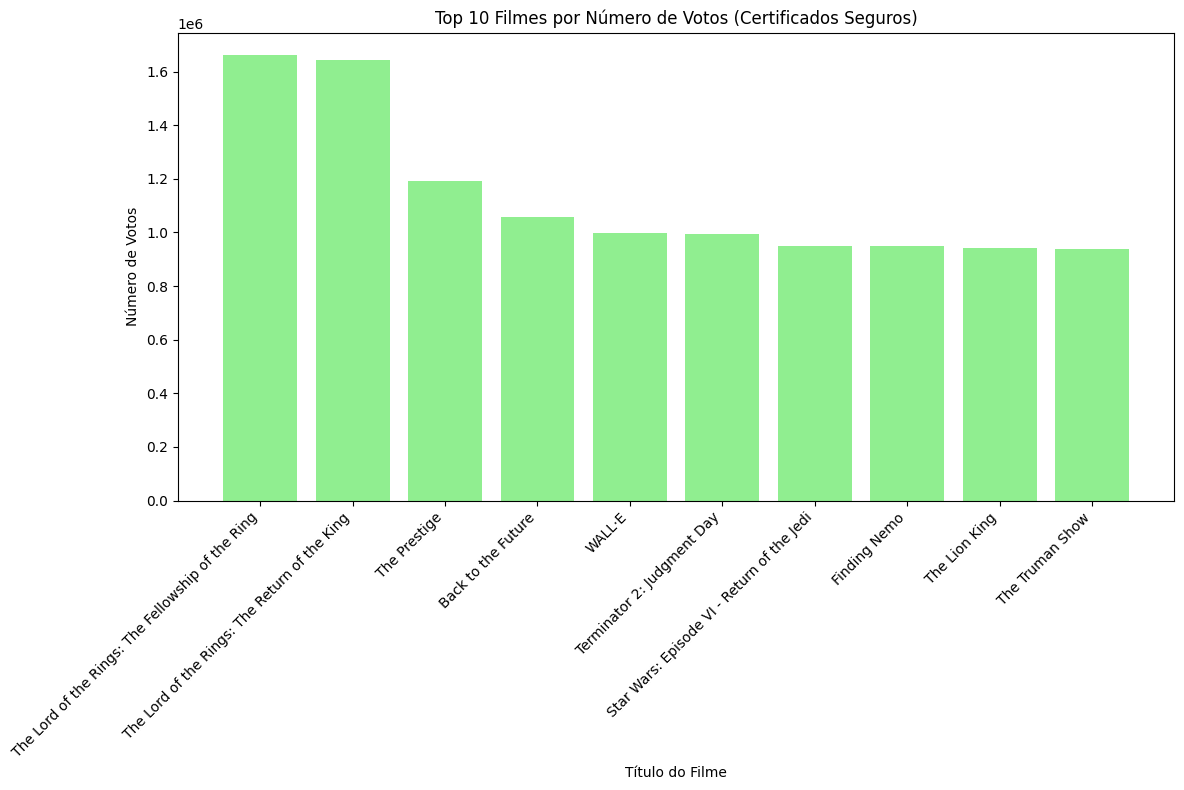

In [568]:
# Gráfico Top 10 Número de Votos
plt.figure(figsize=(12, 8))
plt.bar(top_10_votos['Series_Title'], top_10_votos['No_of_Votes'], color='lightgreen')
plt.title('Top 10 Filmes por Número de Votos (Certificados Seguros)')
plt.xlabel('Título do Filme')
plt.ylabel('Número de Votos')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

 Vendo se algum filme está nos 3 rankings:

In [569]:
# Converter as Series_Title em sets para encontrar a interseção
filmes_imdb = set(top_10_imdb['Series_Title'])
filmes_meta = set(top_10_meta['Series_Title'])
filmes_votos = set(top_10_votos['Series_Title'])

# Encontrar a interseção dos três sets
filmes_em_comum = filmes_imdb.intersection(filmes_meta, filmes_votos)

print(f"Filmes que estão nos Top 10 de IMDB, Meta Score e Votos: {filmes_em_comum}")

Filmes que estão nos Top 10 de IMDB, Meta Score e Votos: set()


Como nenhum filme está nos 3 rankings, vou procurar os que estão em 2 dos 3 rankings:

In [570]:
# Encontrar filmes que estão em pelo menos 2 das 3 listas
filmes_em_comum_dois_criterios = (filmes_imdb.intersection(filmes_meta) |
                                   filmes_imdb.intersection(filmes_votos) |
                                   filmes_meta.intersection(filmes_votos))

print(f"Filmes que estão em pelo menos 2 dos 3 Top 10: {filmes_em_comum_dois_criterios}")

Filmes que estão em pelo menos 2 dos 3 Top 10: {'The Lord of the Rings: The Return of the King', 'The Lion King', 'The Prestige', 'Terminator 2: Judgment Day', 'Shichinin no samurai', 'The Lord of the Rings: The Fellowship of the Ring'}


Comparar o ranking de cada um desses filmes nos 3 rankings:

In [571]:
# Lista de filmes que estão em pelo menos 2 das 3 listas Top 10
filmes_em_comum = {
    'The Lord of the Rings: The Fellowship of the Ring',
    'The Prestige',
    'Shichinin no samurai',
    'The Lord of the Rings: The Return of the King',
    'Terminator 2: Judgment Day',
    'The Lion King'
}

# Certificados de filmes seguros (para contextualizar o ranking)
certificados_seguros = ['G', 'PG', 'U', 'U/A']

# Filtrar o DataFrame original para incluir apenas os filmes com certificados seguros
df_seguros = df[df['Certificate'].isin(certificados_seguros)].copy()

# Remover linhas com valores nulos para evitar erros no ranking
df_seguros.dropna(subset=['IMDB_Rating', 'Meta_score', 'No_of_Votes'], inplace=True)

# Adicionar colunas de ranking ao DataFrame
df_seguros['Rank_IMDB'] = df_seguros['IMDB_Rating'].rank(method='min', ascending=False)
df_seguros['Rank_Meta_score'] = df_seguros['Meta_score'].rank(method='min', ascending=False)
df_seguros['Rank_Votos'] = df_seguros['No_of_Votes'].rank(method='min', ascending=False)

# Filtrar o DataFrame para mostrar apenas os filmes que você listou
df_comparacao = df_seguros[df_seguros['Series_Title'].isin(filmes_em_comum)].copy()

# Ordenar a tabela para melhor visualização (por exemplo, pelo Rank IMDB)
df_comparacao.sort_values(by='Rank_IMDB', inplace=True)

# Imprimir a posição de cada filme em cada ranking
print("Posição de cada filme nos rankings:\n")
for index, row in df_comparacao.iterrows():
    print(f"Filme: {row['Series_Title']}")
    print(f" - Posição no Ranking IMDB: {row['Rank_IMDB']:.0f}")
    print(f" - Posição no Ranking Meta Score: {row['Rank_Meta_score']:.0f}")
    print(f" - Posição no Ranking de Votos: {row['Rank_Votos']:.0f}")
    print("-" * 40)

Posição de cada filme nos rankings:

Filme: The Lord of the Rings: The Return of the King
 - Posição no Ranking IMDB: 2
 - Posição no Ranking Meta Score: 25
 - Posição no Ranking de Votos: 2
----------------------------------------
Filme: The Lord of the Rings: The Fellowship of the Ring
 - Posição no Ranking IMDB: 3
 - Posição no Ranking Meta Score: 34
 - Posição no Ranking de Votos: 1
----------------------------------------
Filme: Shichinin no samurai
 - Posição no Ranking IMDB: 4
 - Posição no Ranking Meta Score: 8
 - Posição no Ranking de Votos: 67
----------------------------------------
Filme: The Prestige
 - Posição no Ranking IMDB: 8
 - Posição no Ranking Meta Score: 213
 - Posição no Ranking de Votos: 3
----------------------------------------
Filme: The Lion King
 - Posição no Ranking IMDB: 8
 - Posição no Ranking Meta Score: 61
 - Posição no Ranking de Votos: 9
----------------------------------------
Filme: Terminator 2: Judgment Day
 - Posição no Ranking IMDB: 8
 - Posiçã

# Eu indico o filme: The Lord of the Rings: The Return of the King. Pois ele é top2 de nota do IMDB, número de votos e top25 de nota dos críticos.

In [572]:
df.describe()

,Released_Year,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross,Gross_Million,Ano,Budget
count,998.000000,999.000000,999.000000,863.000000,9.990000e+02,8.620000e+02,830.000000,998.0,7.660000e+02
mean,1991.214429,122.871872,7.947948,78.015064,2.716214e+05,6.636833e+07,68.082574,1991.214429,3.328768e+07
std,23.308539,28.101227,0.272290,12.377137,3.209126e+05,1.082314e+08,109.807553,23.308539,5.252777e+07
min,1920.000000,45.000000,7.600000,28.000000,2.508800e+04,1.305000e+03,0.001305,1920.0,3.025000e+03
25%,1976.000000,103.000000,7.700000,71.000000,5.547150e+04,3.119146e+06,3.245338,1976.0,3.700000e+06
50%,1999.000000,119.000000,7.900000,79.000000,1.383560e+05,2.312462e+07,23.457439,1999.0,1.250000e+07
75%,2009.000000,137.000000,8.100000,87.000000,3.731675e+05,7.776494e+07,80.876340,2009.0,3.500000e+07
max,2020.000000,321.000000,9.200000,100.000000,2.303232e+06,9.366622e+08,936.662225,2020.0,3.560000e+08


Os filmes do conjunto de dados vão de 1920 até 2020, mas a maior parte é a maior parte é do século XXI, já que metade deles foi lançada depois de 1999. A duração varia bastante, de 45 até mais de 300 minutos, mas em geral ficam perto de duas horas. As notas do IMDb são altas com quase todos os filmes acima de 7,5, o que mostra que são bem avaliados pelo público em geral. Já a avaliação dos críticos (Meta_score) tem uma variação bem maior, indo de 28 até 100. Quando olhamos o número de votos, vemos que muitos filmes receberam menos de 150 mil, enquanto alguns alcançaram milhões, mostrando diferenças grandes de popularidade. O faturamento também é bastante desigual: enquanto metade dos filmes arrecadou menos de 22 milhões de dólares (mediana), alguns chegaram a valores centenas de vezes maiores, elevando bastante a média.

# 2)c) 
A coluna Overview carrega forte sinal de gênero (palavras e/ou expressões típicas de cada tema) e, por isso, é útil na modelagem. Com vetorização de texto (TF-IDF) é possível inferir o gênero principal a partir da sinopse.

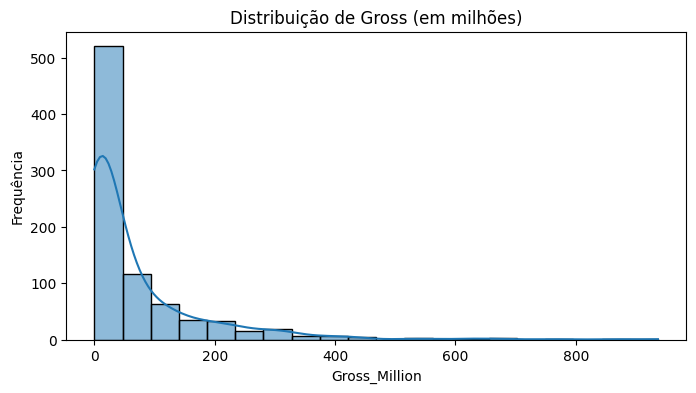

In [573]:
plt.figure(figsize=(8,4))
sns.histplot(df['Gross_Million'], bins=20, kde=True)
plt.title('Distribuição de Gross (em milhões)')
plt.xlabel('Gross_Million')
plt.ylabel('Frequência')
plt.show()

A maioria dos filmes teve baixo faturamento e só alguns tiveram faturamentos muito altos, o que gera assimetria à direita e, com isso, a mediana representa melhor os dados do que a média.

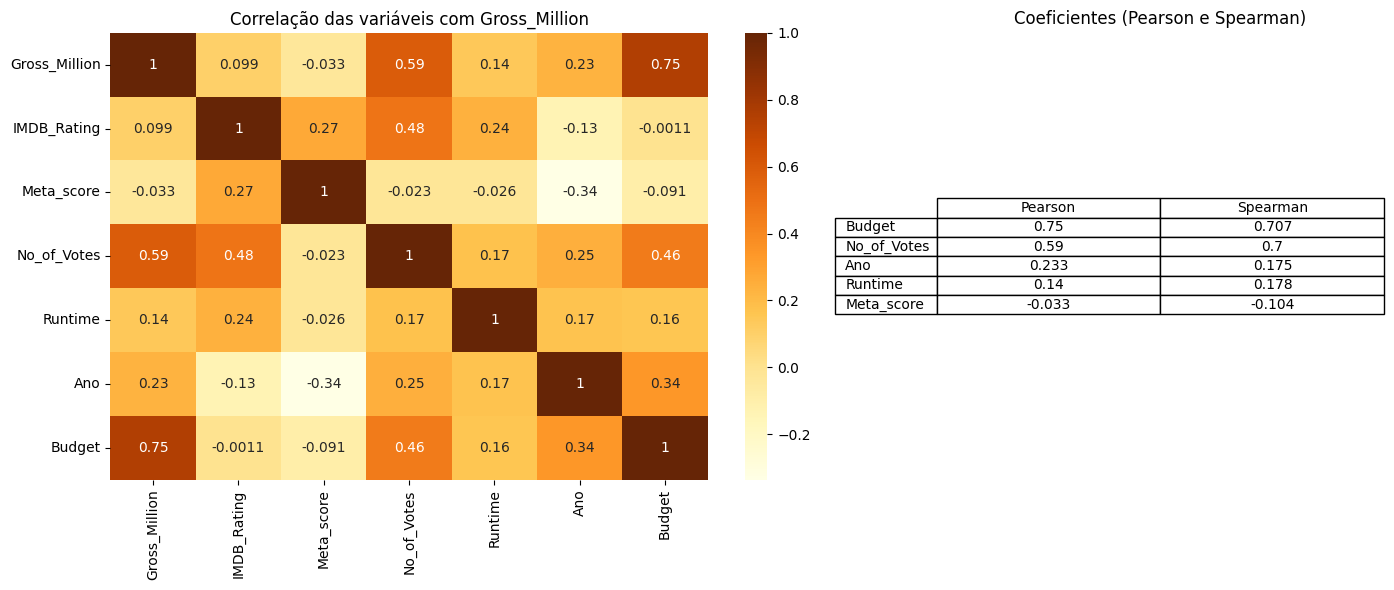

In [574]:
# Heatmap + Tabela
# =====================

# Seleção de colunas
corr_gross = df[['Gross_Million','IMDB_Rating','Meta_score','No_of_Votes','Runtime','Ano','Budget']]

# Correlações detalhadas (Pearson e Spearman)
num_cols = ['No_of_Votes','Meta_score','Runtime','Gross_Million','Ano','Budget']
corrs = pd.DataFrame({
    "Pearson": corr_gross[num_cols].corr(method="pearson")["Gross_Million"],
    "Spearman": corr_gross[num_cols].corr(method="spearman")["Gross_Million"]
}).drop("Gross_Million").sort_values("Pearson", ascending=False)

# Criar layout
fig = plt.figure(figsize=(14,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # heatmap ocupa mais espaço

# ---- Heatmap (lado esquerdo)
ax0 = plt.subplot(gs[0])
sns.heatmap(corr_gross.corr(min_periods=1), annot=True, cmap="YlOrBr", ax=ax0)
ax0.set_title('Correlação das variáveis com Gross_Million')

# ---- Tabela (lado direito)
ax1 = plt.subplot(gs[1])
ax1.axis("off")
tbl = ax1.table(
    cellText=corrs.round(3).values,
    rowLabels=corrs.index,
    colLabels=corrs.columns,
    loc="center",
    cellLoc="center"
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2)
ax1.set_title("Coeficientes (Pearson e Spearman)")

plt.tight_layout()
plt.show()


O orçamento (Budget) é o fator mais fortemente relacionado ao faturamento (Pearson = "0,75"; Spearman = "0,71"), seguido pelo número de votos (Pearson = "0,59"; Spearman = "0,70"), que apresenta correlação moderada. Já a duração ("0,14") e o meta score ("-0,03") têm pouca relação com o Gross.

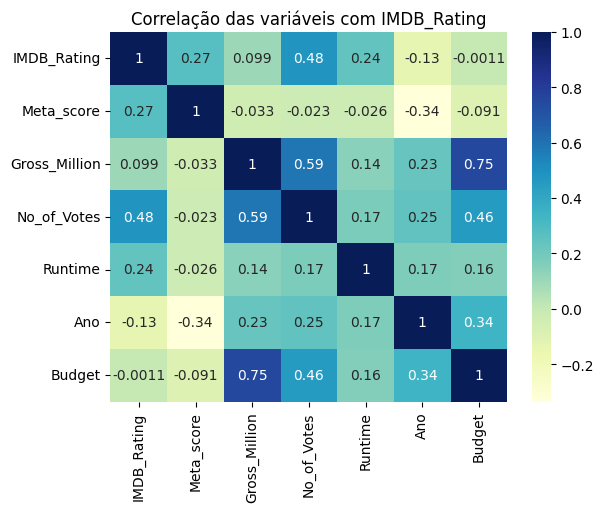

In [575]:
# Mapa de calor com as relações númericas das variáveis númericas com a nota do IMDB
corr_rating = df[['IMDB_Rating','Meta_score','Gross_Million','No_of_Votes','Runtime', 'Ano', 'Budget']]
sns.heatmap(corr_rating.corr(min_periods=1), annot=True, cmap="YlGnBu")
plt.title('Correlação das variáveis com IMDB_Rating')
plt.show()


A nota do IMDB tem correlação moderada com número de votos e fraca com a nota dos críticos. Já faturamento, duração e orçamento praticamente não se relacionam com a nota do IMDB

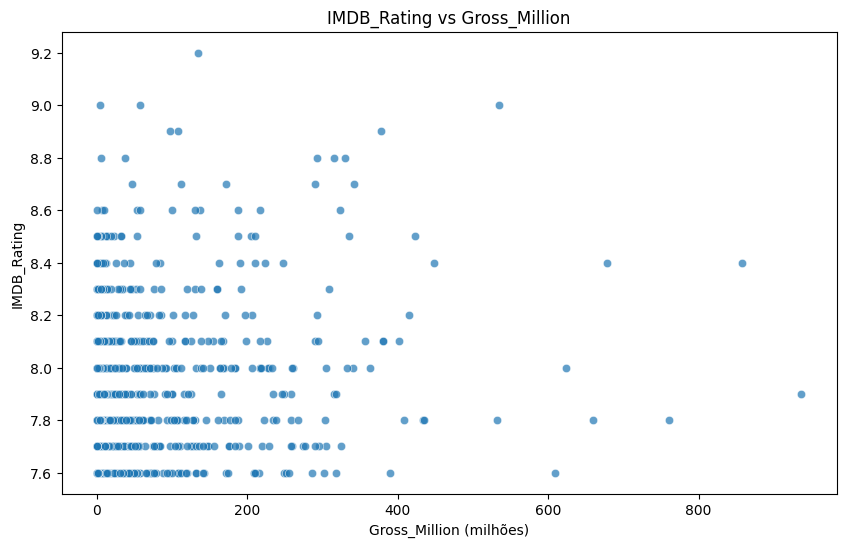

In [576]:
# Relação entre a nota do IMDB e o faturamento
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='Gross_Million', y='IMDB_Rating', alpha=0.7)
plt.title('IMDB_Rating vs Gross_Million')
plt.xlabel('Gross_Million (milhões)')
plt.ylabel('IMDB_Rating')
plt.show()

Não há uma tendência clara: filmes bem avaliados no IMDB nem sempre tem maiores faturamentos. A maioria concentra notas entre 7,5 e 8,5 independentemente do faturamento, mostrando que popularidade financeira e avaliação crítica do público tem quase nenhuma relação

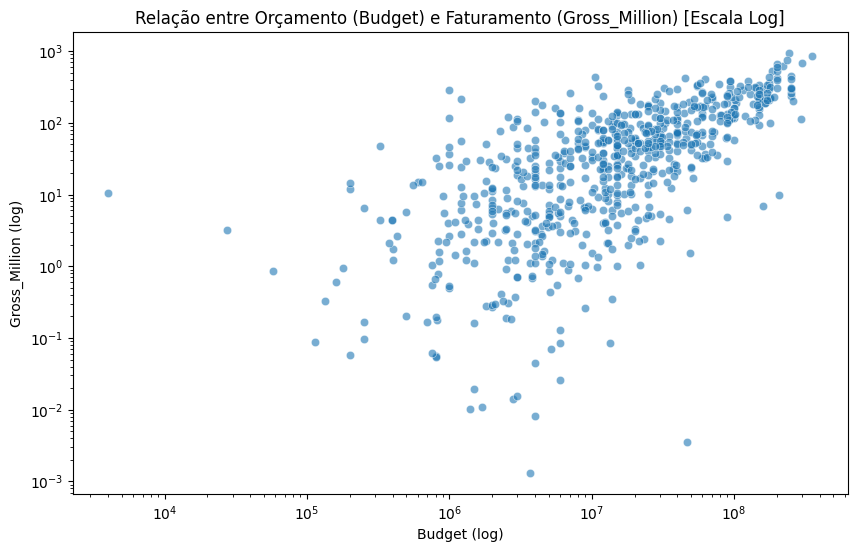

In [577]:
# Relação entre Budget e Gross_Million com escala log-log
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df,
    x="Budget",
    y="Gross_Million",
    alpha=0.6
)

plt.xscale("log")
plt.yscale("log")

plt.title("Relação entre Orçamento (Budget) e Faturamento (Gross_Million) [Escala Log]")
plt.xlabel("Budget (log)")
plt.ylabel("Gross_Million (log)")
plt.show()


Filmes com maiores orçamentos tendem a alcançar faturamentos proporcionalmente mais altos, como era esperado pela forte correlação dessas 2 variáveis (0,75)

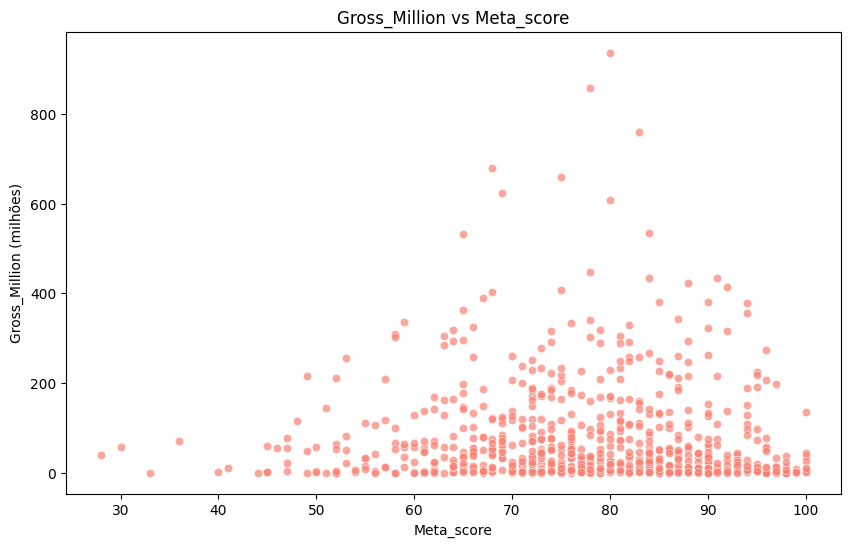

In [578]:
# Relação entre faturamento e a nota dos críticos (Meta_score)
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='Meta_score', y='Gross_Million', alpha=0.7, color='salmon')
plt.title('Gross_Million vs Meta_score')
plt.xlabel('Meta_score')
plt.ylabel('Gross_Million (milhões)')
plt.show()


Não há uma relação clara entre a nota da crítica e o faturamento. Filmes com notas dos críticos altas ou baixas aparecem espalhados em diferentes faixas de bilheteria, mostrando que boas notas dos críticos não garantem um bom faturamento.

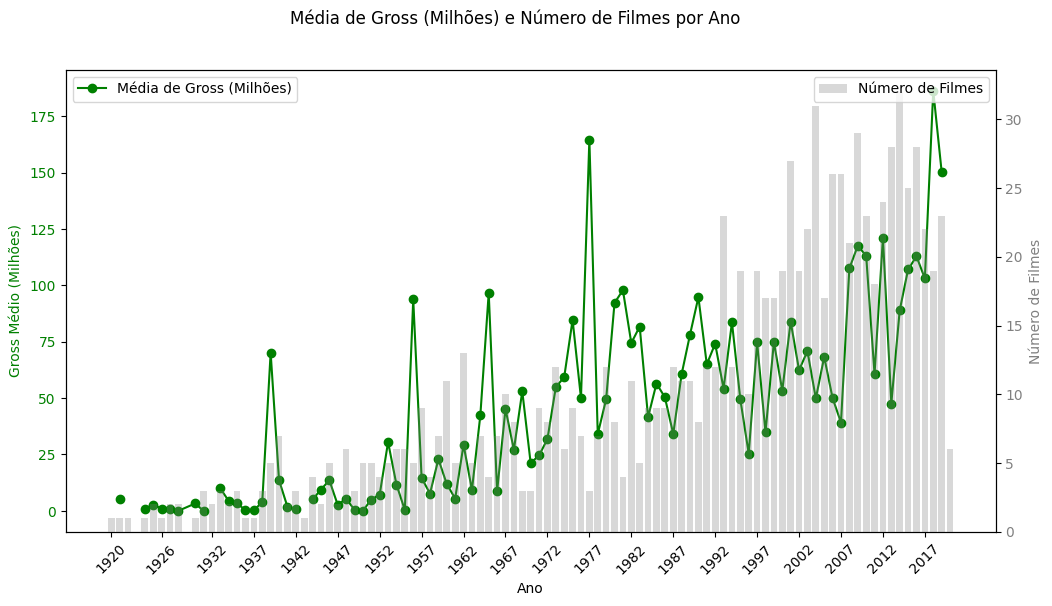

In [579]:
# Evolução do faturamento médio em milhões e da quantidade de filmes por ano
# Agrupar por Ano
stats_gross = df.groupby('Ano').agg({'Gross_Million':'mean', 'Series_Title':'count'}).rename(columns={'Series_Title':'Num_Filmes'})

fig, ax1 = plt.subplots(figsize=(12,6))

# Gráfico da média de Gross_Million
ax1.plot(stats_gross.index, stats_gross['Gross_Million'], marker='o', color='green', label='Média de Gross (Milhões)')
ax1.set_xlabel('Ano')
ax1.set_ylabel('Gross Médio (Milhões)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Reduz número de ticks no eixo X
ax1.set_xticks(stats_gross.index[::5])
ax1.set_xticklabels(stats_gross.index[::5], rotation=45)

# Gráfico da contagem de filmes no eixo direito
ax2 = ax1.twinx()
ax2.bar(stats_gross.index, stats_gross['Num_Filmes'], alpha=0.3, color='gray', label='Número de Filmes')
ax2.set_ylabel('Número de Filmes', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# Título e legendas
fig.suptitle('Média de Gross (Milhões) e Número de Filmes por Ano')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


Com o passar dos anos, vemos um aumento na quantidade de filmes produzidos e também na média de faturamento. Apesar de oscilações em alguns anos específicos, a tendência geral é de crescimento, mostrando a expansão da indústria cinematográfica. Esse aumento pode refletir em parte a seleção de filmes incluídos no dataset, mas ainda assim indica uma tendência clara de crescimento

C:\Users\Technook\AppData\Local\Temp\ipykernel_20048\439300961.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=mean_gross.index, y=mean_gross.values, palette='Blues_r')


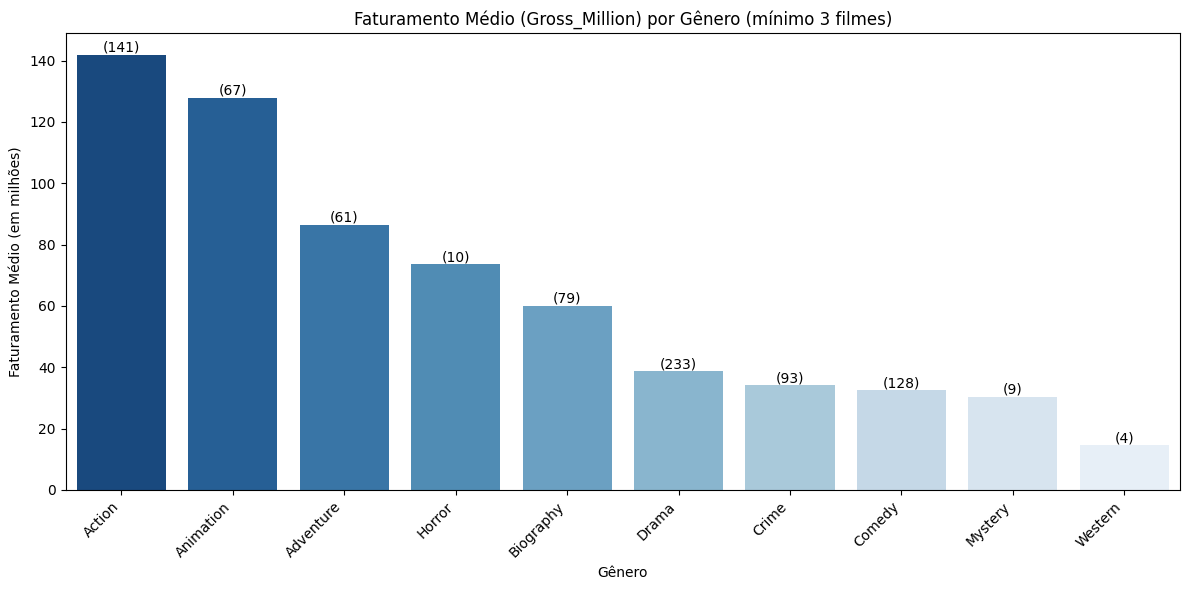

In [580]:
# Faturamento médio por gênero no gráfico de barras
# Filtrar o DataFrame para incluir apenas os filmes que têm um valor de Gross_Million
df_filtrado_gross = df.dropna(subset=['Gross_Million']).copy()

# Calcular a média de Gross_Million para cada Primary_Genre
mean_gross = df_filtrado_gross.groupby('Primary_Genre')['Gross_Million'].mean()

# Calcular a contagem de filmes por gênero
genre_counts = df_filtrado_gross['Primary_Genre'].value_counts()

# Manter apenas gêneros com 3 ou mais filmes
valid_genres = genre_counts[genre_counts >= 3].index
mean_gross = mean_gross.loc[valid_genres].sort_values(ascending=False)

# Criar o gráfico de barras
plt.figure(figsize=(12,6))
ax = sns.barplot(x=mean_gross.index, y=mean_gross.values, palette='Blues_r')

# Adicionar o número de filmes como rótulo em cada barra
for i, p in enumerate(ax.patches):
    genre = mean_gross.index[i]
    count = genre_counts.get(genre, 0)
    ax.text(p.get_x() + p.get_width()/2, p.get_height(), f'({count})',
            ha='center', va='bottom', fontsize=10)

# Adicionar títulos e rótulos
plt.title('Faturamento Médio (Gross_Million) por Gênero (mínimo 3 filmes)')
plt.xlabel('Gênero')
plt.ylabel('Faturamento Médio (em milhões)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Podemos ver que os gêneros de ação e animação possuem um faturamento médio muito maior que o dos outros gêneros. Isso indica que a escolha do genero é um fator que influencia muito na expectativa de faturamento do filme.
Se olharmos também os filmes com dois gêneros, talvez aparecessem combinações ainda mais fortes. Mas mesmo nessa versão simplificada, já fica bem clara a diferença enorme entre ação e animação e os outros gêneros.

C:\Users\Technook\AppData\Local\Temp\ipykernel_20048\3910566828.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=mean_gross.index, y=mean_gross.values, palette='coolwarm')


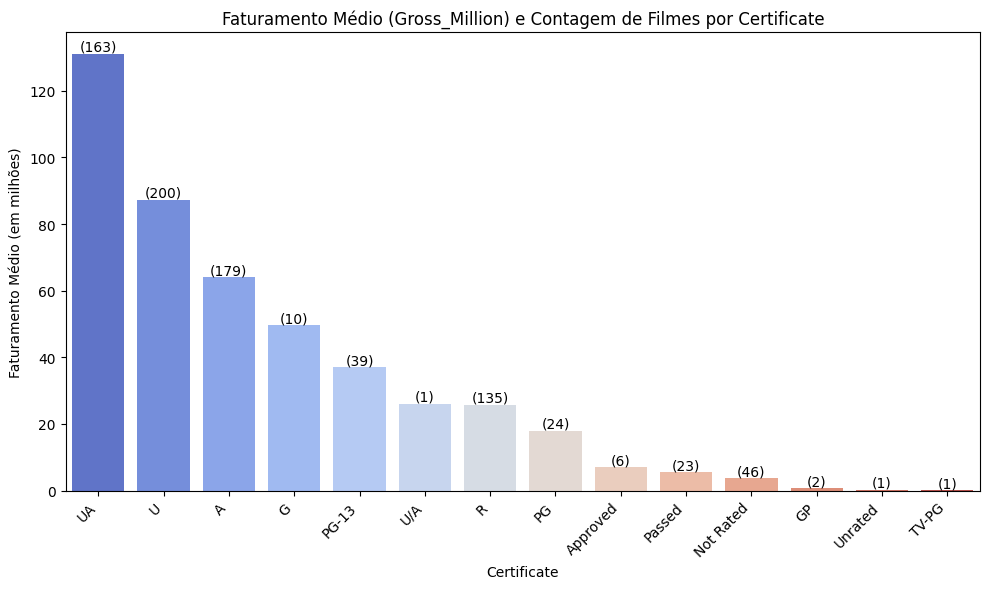

In [581]:
# Faturamento médio por classificação etária
# Filtrar o DataFrame para incluir apenas os filmes que têm um valor de Gross_Million
df_filtrado_gross = df.dropna(subset=['Gross_Million']).copy()

# Calcular a média de Gross_Million para cada Certificate no DataFrame filtrado
mean_gross = df_filtrado_gross.groupby('Certificate')['Gross_Million'].mean().sort_values(ascending=False)

# Calcular a contagem de filmes para cada certificado no DataFrame filtrado
certificate_counts = df_filtrado_gross['Certificate'].value_counts()

# Criar o gráfico de barras
plt.figure(figsize=(10,6))
ax = sns.barplot(x=mean_gross.index, y=mean_gross.values, palette='coolwarm')

# Adicionar o número de filmes como rótulo de texto em cada barra
for p in ax.patches:
    certificate = p.get_x() + p.get_width() / 2
    # Usar .get() com um valor padrão para evitar erros caso um certificado não tenha contagem
    count = certificate_counts.get(mean_gross.index[int(certificate)], 0)
    ax.text(certificate, p.get_height(), f'({count})', ha='center', va='bottom', fontsize=10)

# Adicionar títulos e rótulos
plt.title('Faturamento Médio (Gross_Million) e Contagem de Filmes por Certificate')
plt.xlabel('Certificate')
plt.ylabel('Faturamento Médio (em milhões)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [582]:
# Calcular a média de faturamento dos certificados UA e U
media_ua_u = df_filtrado_gross[df_filtrado_gross['Certificate'].isin(['UA', 'U'])]['Gross_Million'].mean()

# Calcular a média de faturamento dos filmes com certificado A
media_a = df_filtrado_gross[df_filtrado_gross['Certificate'] == 'A']['Gross_Million'].mean()

print(f"Média UA+U: {media_ua_u:.1f}")
print(f"Média A: {media_a:.1f}")


Média UA+U: 107.0
Média A: 64.1


Podemos ver que os filmes com maior média de faturamento são os menos restritos (UA = sem restrições, mas com cautela para menores de 12 anos; U = sem restrição nenhuma). Calculando a média de U e UA e comparando aos filmes adultos, vemos que ela é quase o dobro (103,7 contra 63,5). Isso sugere que ter poucas restrições de faixa etária é um fator relevante para alcançar grandes bilheteiras, provavelmente porque esses filmes podem atingir um público mais amplo.

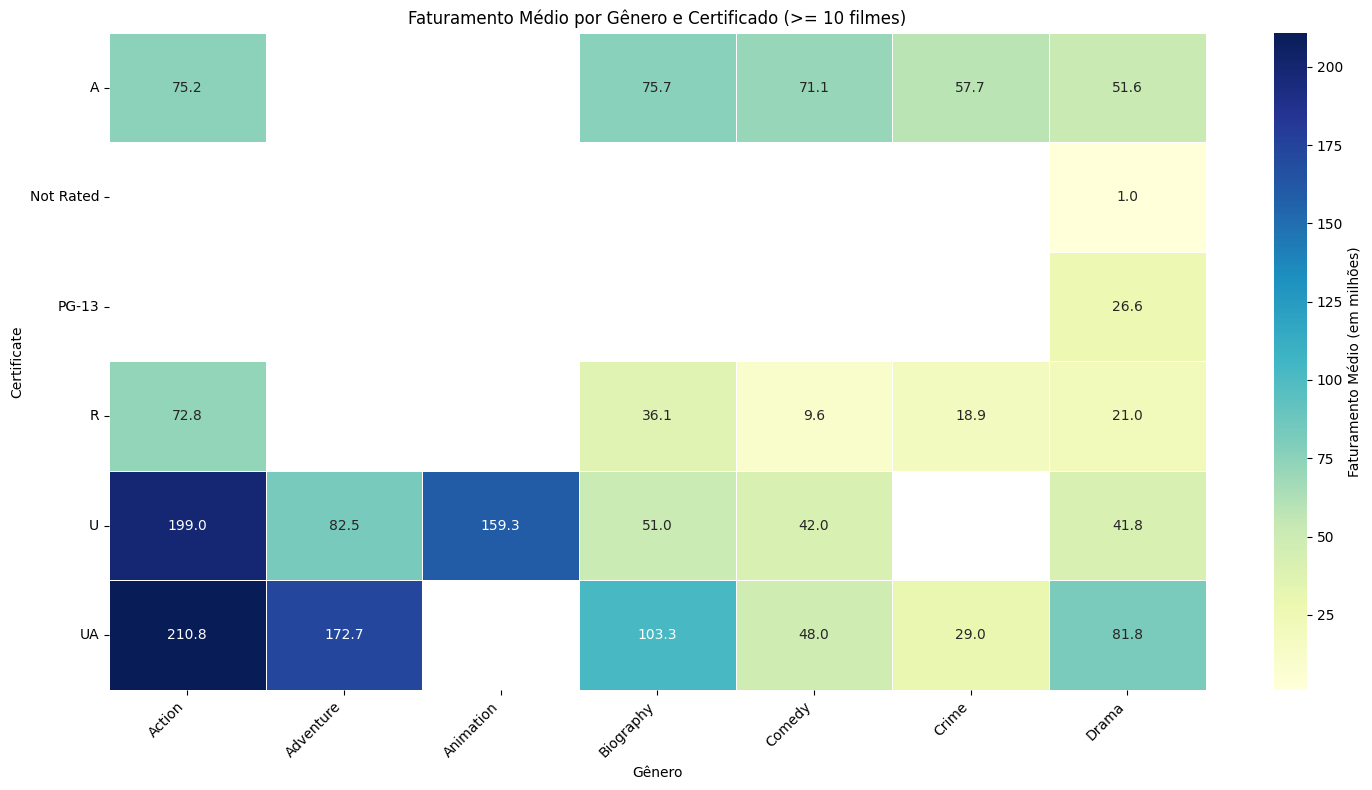

In [583]:
# Mapa de calor com combinações de gÊnero e faixa etária relacionados ao faturamento médio
# Agrupar os dados por Certificate e Primary_Genre e calcular a média e a contagem
# Remover filmes sem faturamento para a análise
df_clean = df.dropna(subset=['Gross_Million']).copy()
grouped_data = df_clean.groupby(['Certificate', 'Primary_Genre']).agg(
    mean_gross=('Gross_Million', 'mean'),
    count=('Series_Title', 'count')
)

# Filtrar o DataFrame para manter apenas as combinações com 10 ou mais filmes
filtered_data = grouped_data[grouped_data['count'] >= 10]

# Criar a tabela dinâmica (pivot table) a partir dos dados filtrados
pivot_table = filtered_data.reset_index().pivot_table(
    values='mean_gross',
    index='Certificate',
    columns='Primary_Genre'
)

# Criar o heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(
    pivot_table,
    annot=True, # Adicionar os valores numéricos no gráfico
    fmt=".1f", # Formatar os números para uma casa decimal
    cmap="YlGnBu", # Escolher o esquema de cores
    linewidths=.5,
    cbar_kws={'label': 'Faturamento Médio (em milhões)'}
)

# Adicionar títulos e rótulos
plt.title('Faturamento Médio por Gênero e Certificado (>= 10 filmes)')
plt.xlabel('Gênero')
plt.ylabel('Certificate')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

Esse gráfico que relaciona combinações de faixa etária e gênero por faturamento, nos trouxe a informação adicional que além das categorias já citadas nas 2 análises anteriores, os filmes de aventura com pouca restrição de idade tem o terceiro melhor faturamento dentre todas as combinações com pelo menos 10 filmes.

O gráfico mostra que não existe uma relação clara entre duração e faturamento. A maior parte dos filmes se concentra entre 90 e 150 minutos, mas com grande variação de bilheteira dentro dessa faixa. Isso é confirmado pela correlação fraca entre as variáveis (≈0,14), indicando que o tempo de duração não é determinante para o sucesso de bilheteira nos cinemas.

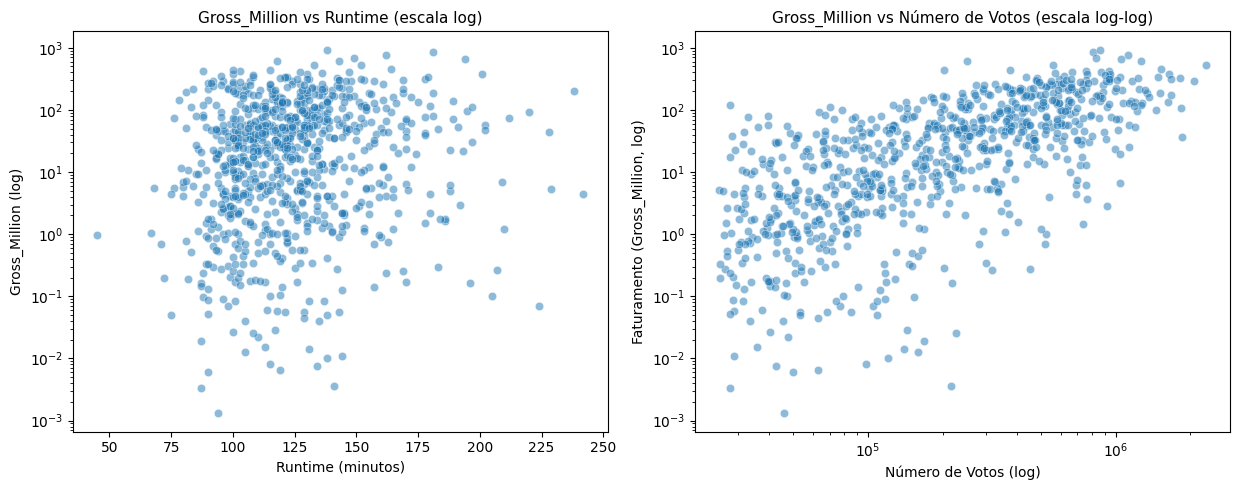

In [584]:
# Comparação: duração vs faturamento e número de votos vs faturamento
fig, axes = plt.subplots(1, 2, figsize=(12.5,5))  # largura menor para caber bem lado a lado

# Scatter 1 - Runtime vs Gross
sns.scatterplot(
    data=df, x='Runtime', y='Gross_Million', alpha=0.5, ax=axes[0]
)
axes[0].set_yscale('log')
axes[0].set_title('Gross_Million vs Runtime (escala log)', fontsize=11)
axes[0].set_xlabel('Runtime (minutos)', fontsize=10)
axes[0].set_ylabel('Gross_Million (log)', fontsize=10)

# Scatter 2 - No_of_Votes vs Gross
sns.scatterplot(
    data=df, x='No_of_Votes', y='Gross_Million', alpha=0.5, ax=axes[1]
)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title('Gross_Million vs Número de Votos (escala log-log)', fontsize=11)
axes[1].set_xlabel('Número de Votos (log)', fontsize=10)
axes[1].set_ylabel('Faturamento (Gross_Million, log)', fontsize=10)

plt.tight_layout()
plt.show()


Essa comparação mostra que a duração dos filmes não tem relação clara com o faturamento: a maioria se concentra entre 90 e 150 minutos, mas com grande variação de faturamento dentro dessa faixa (correlação ≈0,14). Já o número de votos apresenta uma relação bem definida: quanto mais pessoas votam em um filme, maior tende a ser seu faturamento (confirmando a correlação moderada ≈0,60 que foi mostrada em gráfico anterior). Isso mostra que o número de votos (que representa o engajamento do público) é um fator muito mais relevante para o sucesso financeiro do que o tempo de duração.

C:\Users\Technook\AppData\Local\Temp\ipykernel_20048\3305433009.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax0.set_xticklabels(ax0.get_xticklabels(), rotation=45, ha='right')


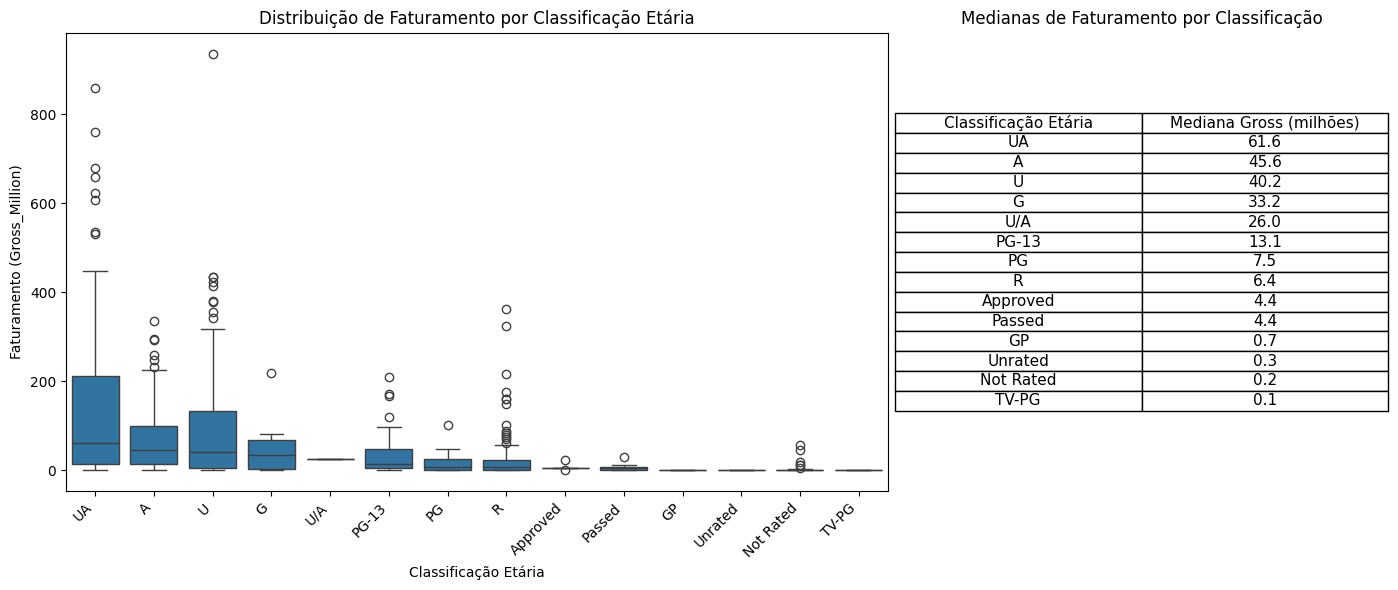


Kruskal-Wallis p-value (Certificate vs Gross): 3.7518336557628696e-35


In [585]:

# Faturamento por classificação etária (Certificate)
# =====================

# Criar coluna Certificate_clean (se ainda não existir)
if 'Certificate' in df.columns:
    df['Certificate_clean'] = df['Certificate'].fillna('Not Rated')
    df['Certificate_clean'] = df['Certificate_clean'].str.strip() 


if 'Certificate_clean' in df.columns:   # usa df direto
    # Calcular medianas
    cert_medians = (
        df.groupby('Certificate_clean')['Gross_Million']
        .median()
        .dropna()
        .sort_values(ascending=False)
    )


    # Criar figura lado a lado
    fig = plt.figure(figsize=(14,6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])

    # Boxplot (esquerda)
    ax0 = fig.add_subplot(gs[0])
    sns.boxplot(
        x='Certificate_clean',
        y='Gross_Million',
        data=df,
        order=cert_medians.index if len(cert_medians) > 0 else None,
        ax=ax0
    )
    ax0.set_xticklabels(ax0.get_xticklabels(), rotation=45, ha='right')
    ax0.set_title('Distribuição de Faturamento por Classificação Etária')
    ax0.set_xlabel("Classificação Etária")
    ax0.set_ylabel("Faturamento (Gross_Million)")

    # Tabela (direita)
    ax1 = fig.add_subplot(gs[1])
    ax1.axis("off")
    cell_data = cert_medians.reset_index()
    cell_data['Gross_Million'] = cell_data['Gross_Million'].map(lambda x: f"{x:,.1f}")
    tbl = ax1.table(
        cellText=cell_data.values,
        colLabels=["Classificação Etária", "Mediana Gross (milhões)"],
        cellLoc="center", loc="center"
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(11)
    tbl.scale(1.2, 1.2)
    ax1.set_title("Medianas de Faturamento por Classificação")

    plt.tight_layout()
    plt.show()

    # Teste estatístico Kruskal-Wallis
    groups = [g['Gross_Million'].dropna().values for _, g in df.groupby('Certificate_clean')]
    cert_p = stats.kruskal(*[g for g in groups if len(g) > 0]).pvalue
    print("\nKruskal-Wallis p-value (Certificate vs Gross):", cert_p)


Os dados reforçam que ação e animação são os gêneros que mais se destacam em faturamento médio, ficando bem à frente dos demais. Isso mostra que a escolha do gênero tem grande peso no potencial de sucesso nas bilheterias de um filme. Quando olhamos para combinações de dois gêneros, algumas uniões, como ação com aventura, turbinam ainda mais os faturamentos de filmes de ação. Mesmo nessa comparação a distância entre ação e animação para outros gêneros continua bem clara, com exceção da combinação de aventura como gênero principal com fámilia e fantasia como gêneros secundários.

A partir das análises exploratórias realizadas, identificamos que os fatores mais relacionados a uma alta expectativa de faturamento são:

- O número de votos no IMDB, que apresenta correlação moderada (≈0,6) com a bilheteria, indicando que filmes mais populares tendem a gerar maior receita;

- O gênero principal, em que “Ação” e “Animação” se destacam com médias de faturamento bem acima das demais categorias;

- A classificação etária, já que filmes com restrições menores (livres para públicos amplos) registram faturamentos consistentemente mais altos, enquanto classificações mais restritivas (PG-13, R e A) apresentam medianas menores.

- Além disso, a análise de combinações revelou que filmes de Aventura com classificação pouco restrita apresentam o terceiro maior faturamento médio entre todas as categorias, reforçando que gênero e faixa etária devem ser considerados de forma conjunta, e não isolada, ao definir a estratégia de produção.

### IMDB rating

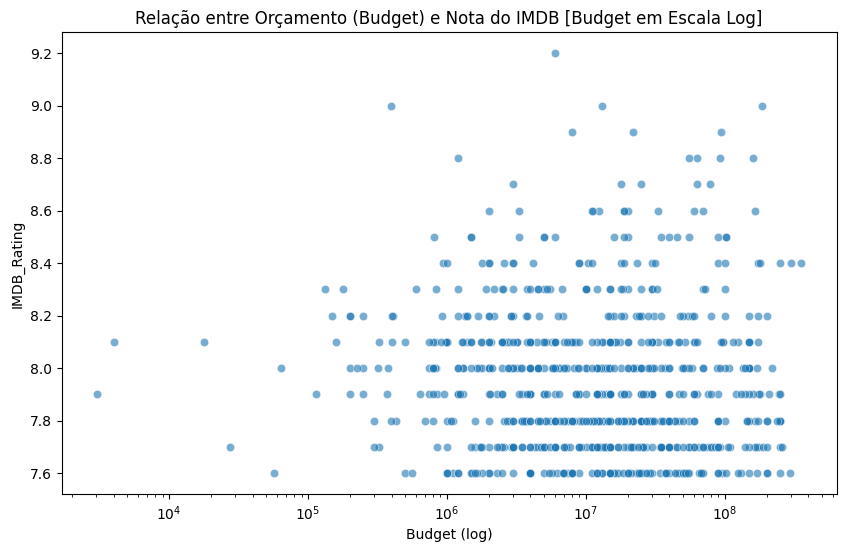

In [586]:
# Relação entre Budget e IMDB_Rating (Budget em escala log)
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df,
    x="Budget",
    y="IMDB_Rating",
    alpha=0.6
)

plt.xscale("log")
plt.title("Relação entre Orçamento (Budget) e Nota do IMDB [Budget em Escala Log]")
plt.xlabel("Budget (log)")
plt.ylabel("IMDB_Rating")
plt.show()


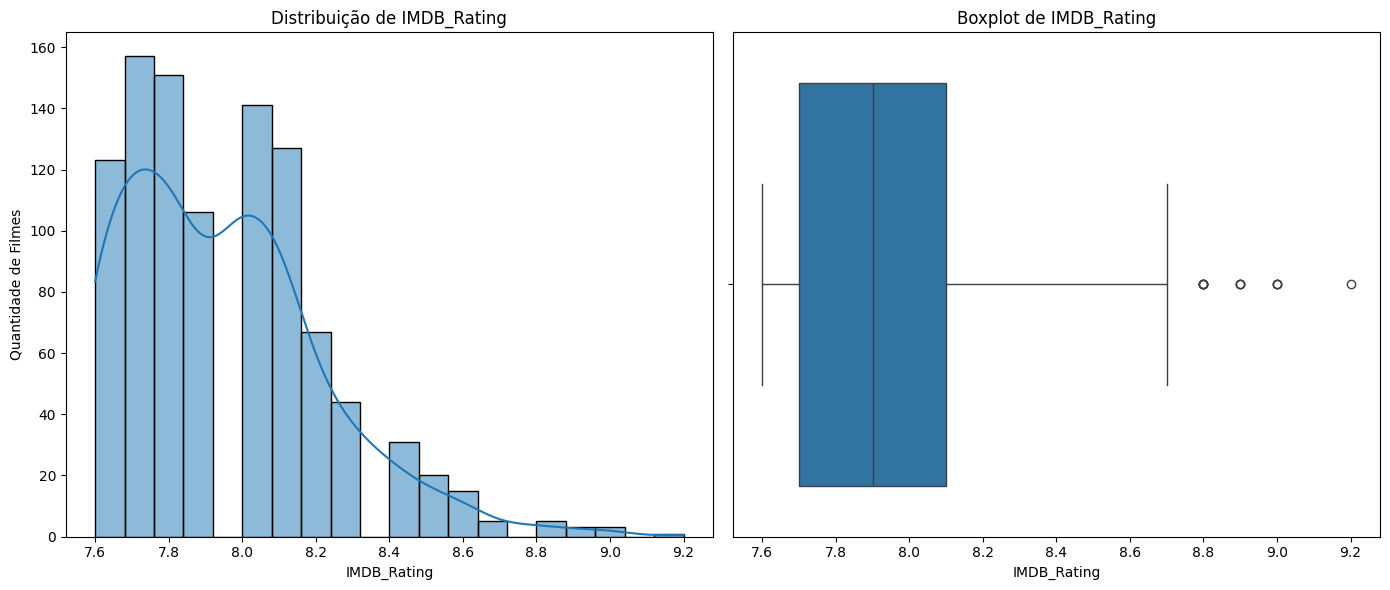

In [587]:
# Distribuição da nota do IMDB (histograma + boxplot lado a lado)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 linha, 2 colunas

# Histograma
sns.histplot(df['IMDB_Rating'], bins=20, kde=True, ax=axes[0])
axes[0].set_title("Distribuição de IMDB_Rating")
axes[0].set_xlabel("IMDB_Rating")
axes[0].set_ylabel("Quantidade de Filmes")

# Boxplot
sns.boxplot(x=df['IMDB_Rating'], ax=axes[1])
axes[1].set_title("Boxplot de IMDB_Rating")
axes[1].set_xlabel("IMDB_Rating")

plt.tight_layout()
plt.show()


As notas do IMDB se concentram principalmente entre 7,6 e 8,2, com uma leve cauda à direita. O boxplot confirma que a variação é pequena e que existem apenas alguns poucos outliers, localizados nas notas mais altas (por volta de 8,8 a 9,2).

C:\Users\Technook\AppData\Local\Temp\ipykernel_20048\4011930116.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
C:\Users\Technook\AppData\Local\Temp\ipykernel_20048\4011930116.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


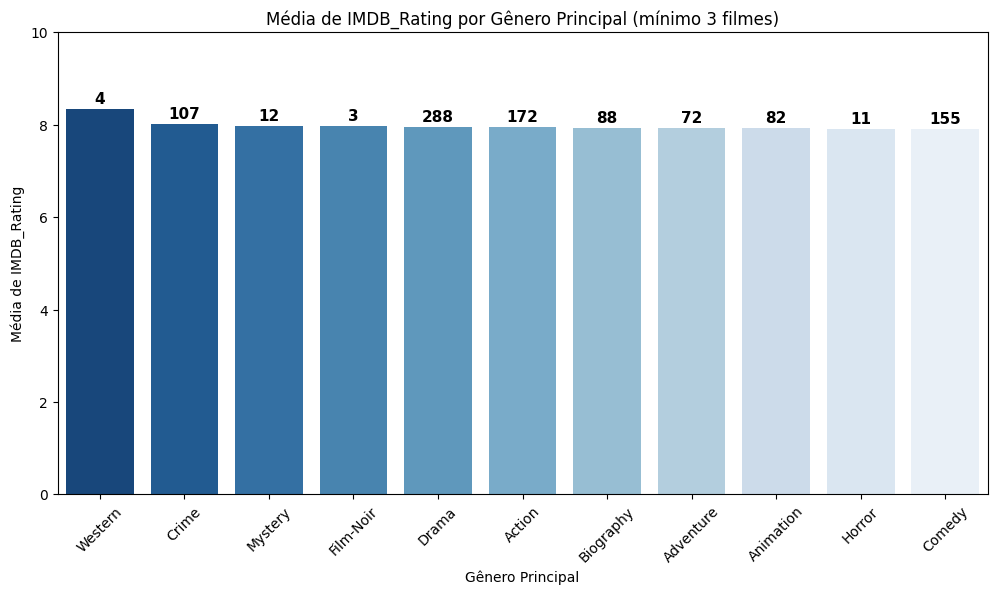

In [588]:
# Nota do IMDB por gênero (top10)
# Agrupar por gênero e calcular média + contagem de notas não nulas
genre_stats = (
    df.groupby('Primary_Genre')
    .agg(
        mean_rating=('IMDB_Rating', 'mean'),
        count_rating=('IMDB_Rating', 'count')  # conta apenas valores não nulos
    )
    .reset_index()
)

# Filtrar apenas gêneros com pelo menos 3 filmes
genre_stats = genre_stats[genre_stats['count_rating'] >= 3]

# Ordenar por média
genre_stats = genre_stats.sort_values('mean_rating', ascending=False)

# Plot
plt.figure(figsize=(12,6))
ax = sns.barplot(
    data=genre_stats,
    x='Primary_Genre',
    y='mean_rating',
    ci=None,
    palette='Blues_r'
)

# Rotacionar labels do eixo X
plt.xticks(rotation=45)

# Adicionar contagem em cada barra (usando patches para alinhar certo)
for bar, count in zip(ax.patches, genre_stats['count_rating']):
    ax.text(
        bar.get_x() + bar.get_width()/2,   # centro da barra
        bar.get_height() + 0.05,           # logo acima do topo da barra
        str(count),                        # apenas o número
        ha='center', va='bottom', fontsize=11, fontweight='bold'
    )

plt.title('Média de IMDB_Rating por Gênero Principal (mínimo 3 filmes)')
plt.xlabel('Gênero Principal')
plt.ylabel('Média de IMDB_Rating')
plt.ylim(0, 10)  # garante escala de 0 a 10 para notas
plt.show()


Com exceção do gênero Velho Oeste, que ficou um pouco acima, os demais gêneros com pelo menos 3 filmes têm médias muito parecidas, mostrando que o gênero tem pouca influência na avaliação do público.

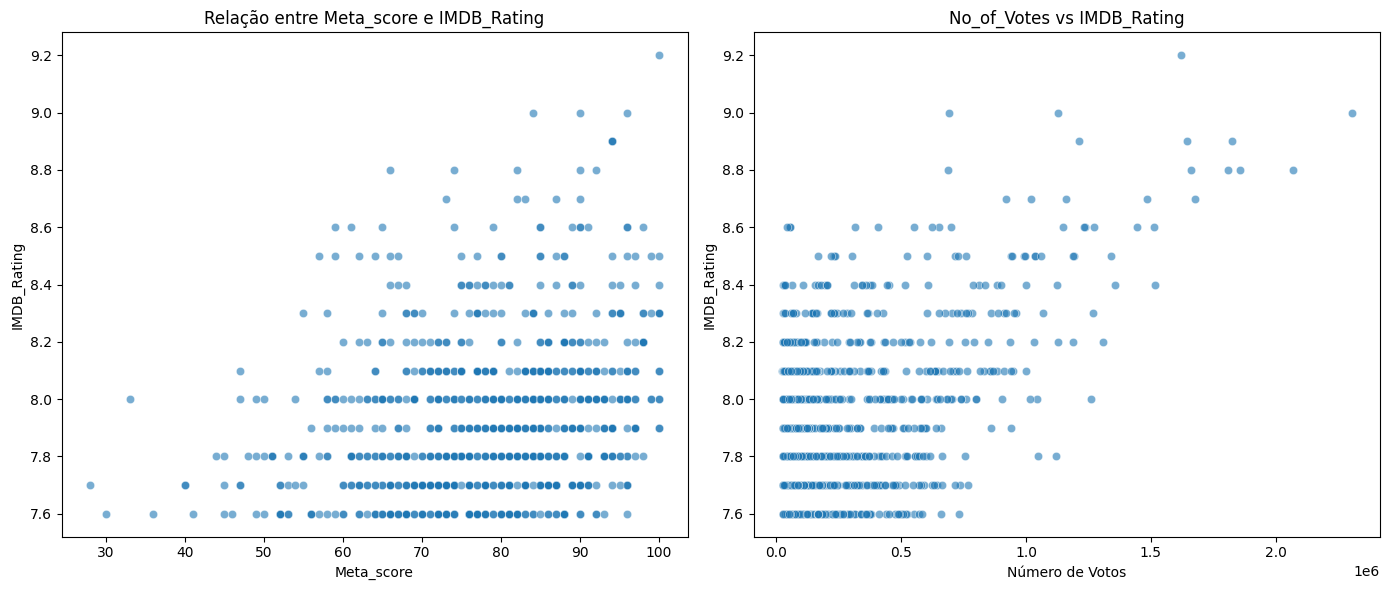

In [589]:
# Gráficos lado a lado: Meta_score vs IMDB_Rating e No_of_Votes vs IMDB_Rating
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Nota do IMDB e nota dos críticos
sns.scatterplot(data=df, x='Meta_score', y='IMDB_Rating', alpha=0.6, ax=axes[0])
axes[0].set_title('Relação entre Meta_score e IMDB_Rating')
axes[0].set_xlabel('Meta_score')
axes[0].set_ylabel('IMDB_Rating')

# Número de votos vs Nota do IMDB
sns.scatterplot(data=df, x='No_of_Votes', y='IMDB_Rating', alpha=0.6, ax=axes[1])
axes[1].set_title('No_of_Votes vs IMDB_Rating')
axes[1].set_xlabel('Número de Votos')
axes[1].set_ylabel('IMDB_Rating')

plt.tight_layout()
plt.show()


Os dois gráficos mostram que tanto o Meta_score quanto o número de votos têm relação positiva com a nota do IMDB, mas em intensidades diferentes. No caso do Meta_score, a correlação é fraca (0,27), indicando apenas uma tendência leve de que filmes bem avaliados pela crítica também recebam boas notas do público. Já o número de votos apresenta uma correlação um pouco mais forte, de 0,48, sugerindo que o engajamento do público (maior número de votos) tem um peso maior para se obter uma melhor nota do IMDB do que as notas dos críticos de cinema.

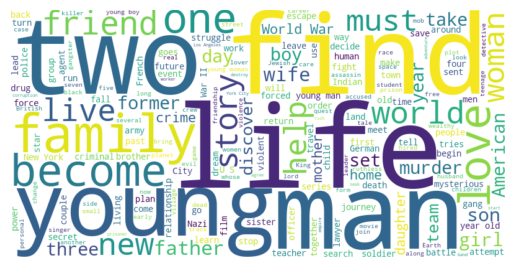

In [590]:
from wordcloud import WordCloud

text = " ".join(df['Overview'])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

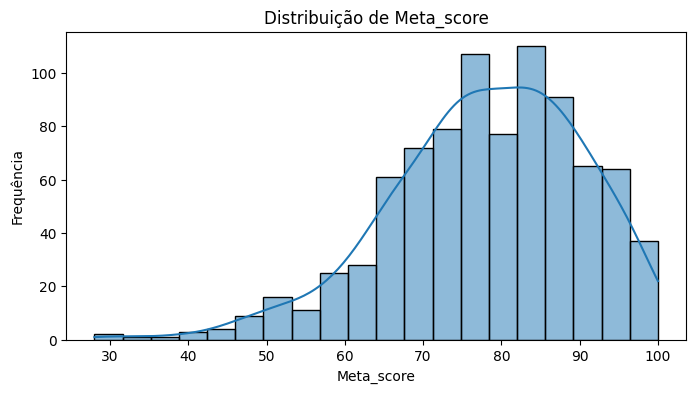

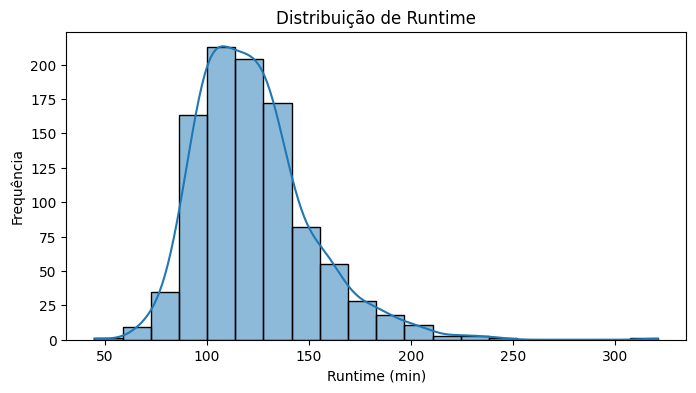

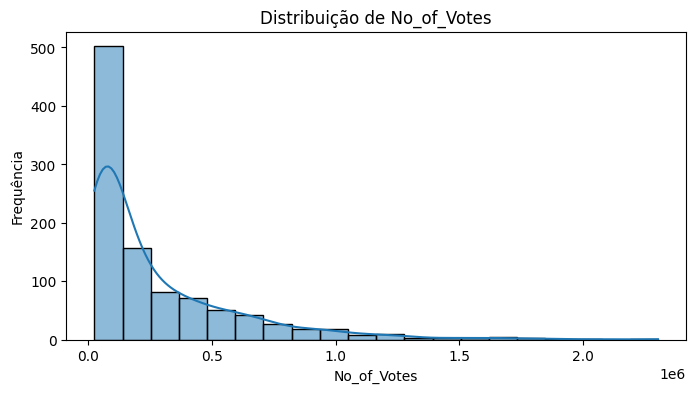

C:\Users\Technook\AppData\Local\Temp\ipykernel_20048\2582437370.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='Primary_Genre', order=df['Primary_Genre'].value_counts().index, palette='pastel')


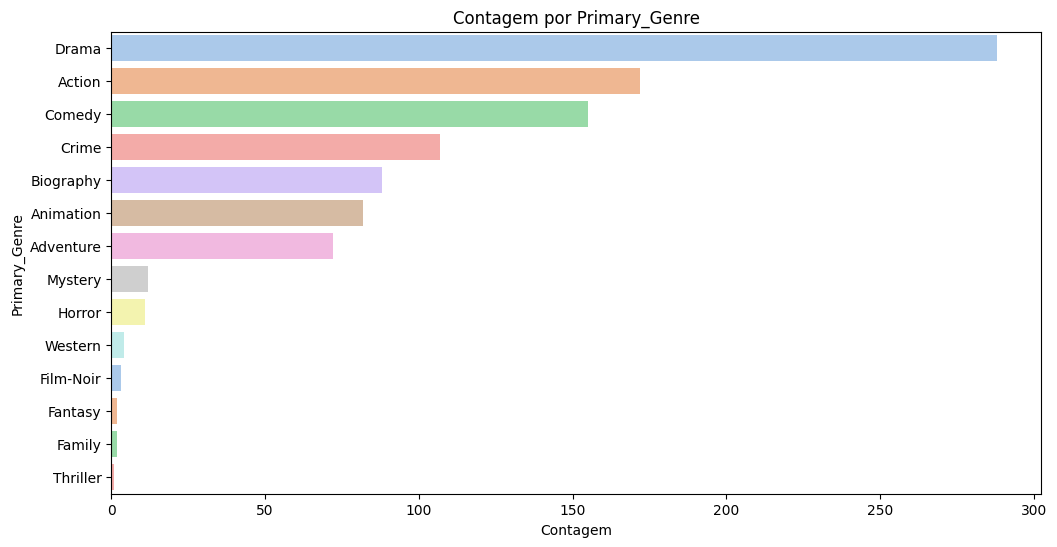

C:\Users\Technook\AppData\Local\Temp\ipykernel_20048\2582437370.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='Certificate', order=df['Certificate'].value_counts().index, palette='pastel')


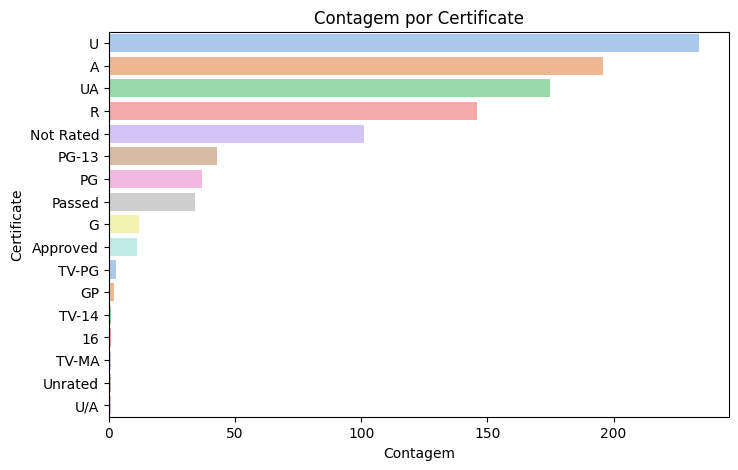

C:\Users\Technook\AppData\Local\Temp\ipykernel_20048\2582437370.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df[df['Director'].isin(top_dirs)], y='Director', order=top_dirs, palette='pastel')


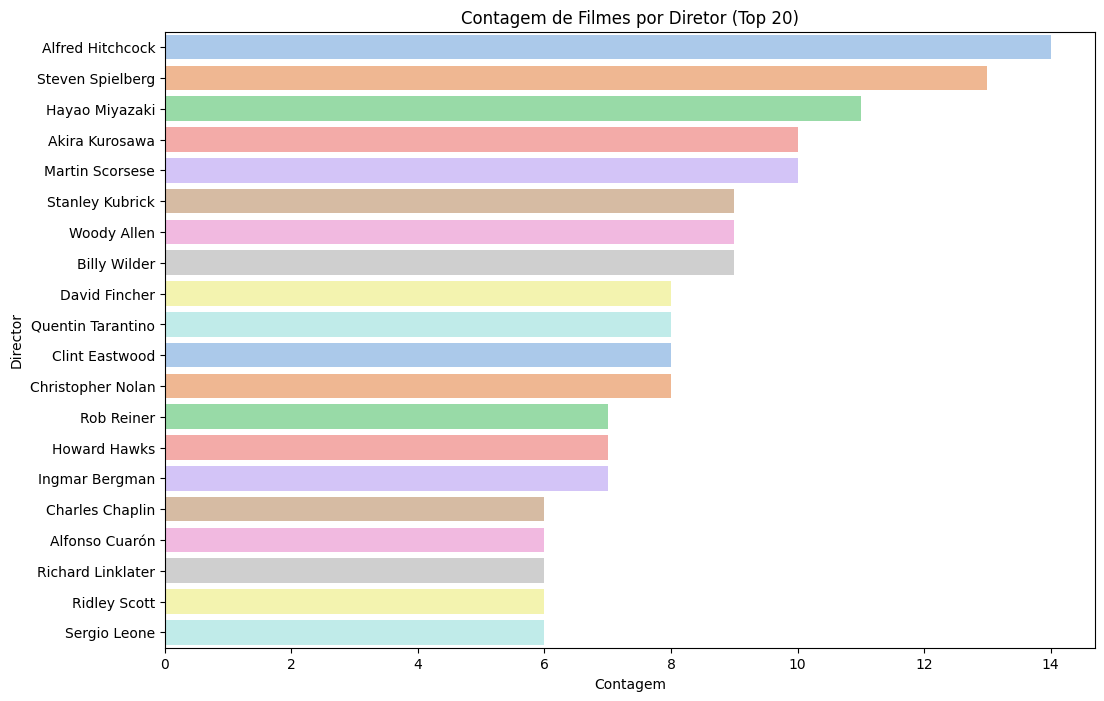

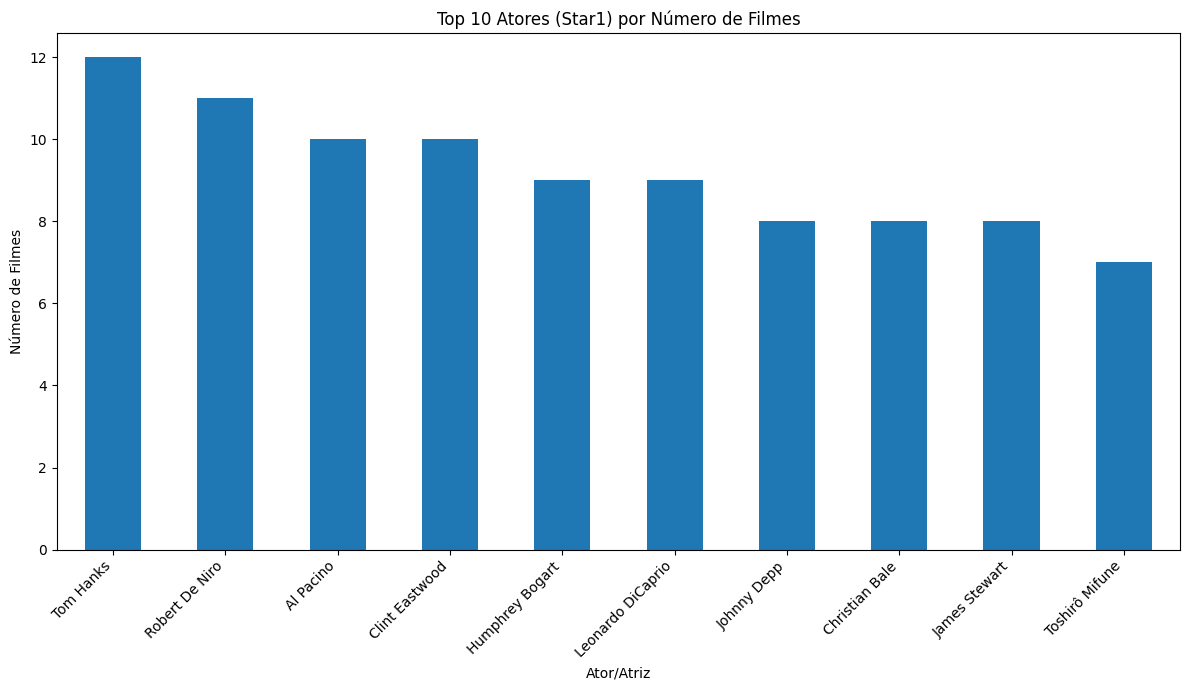

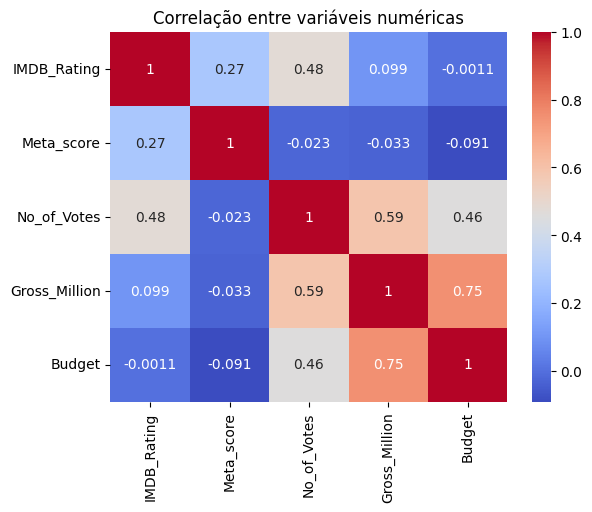

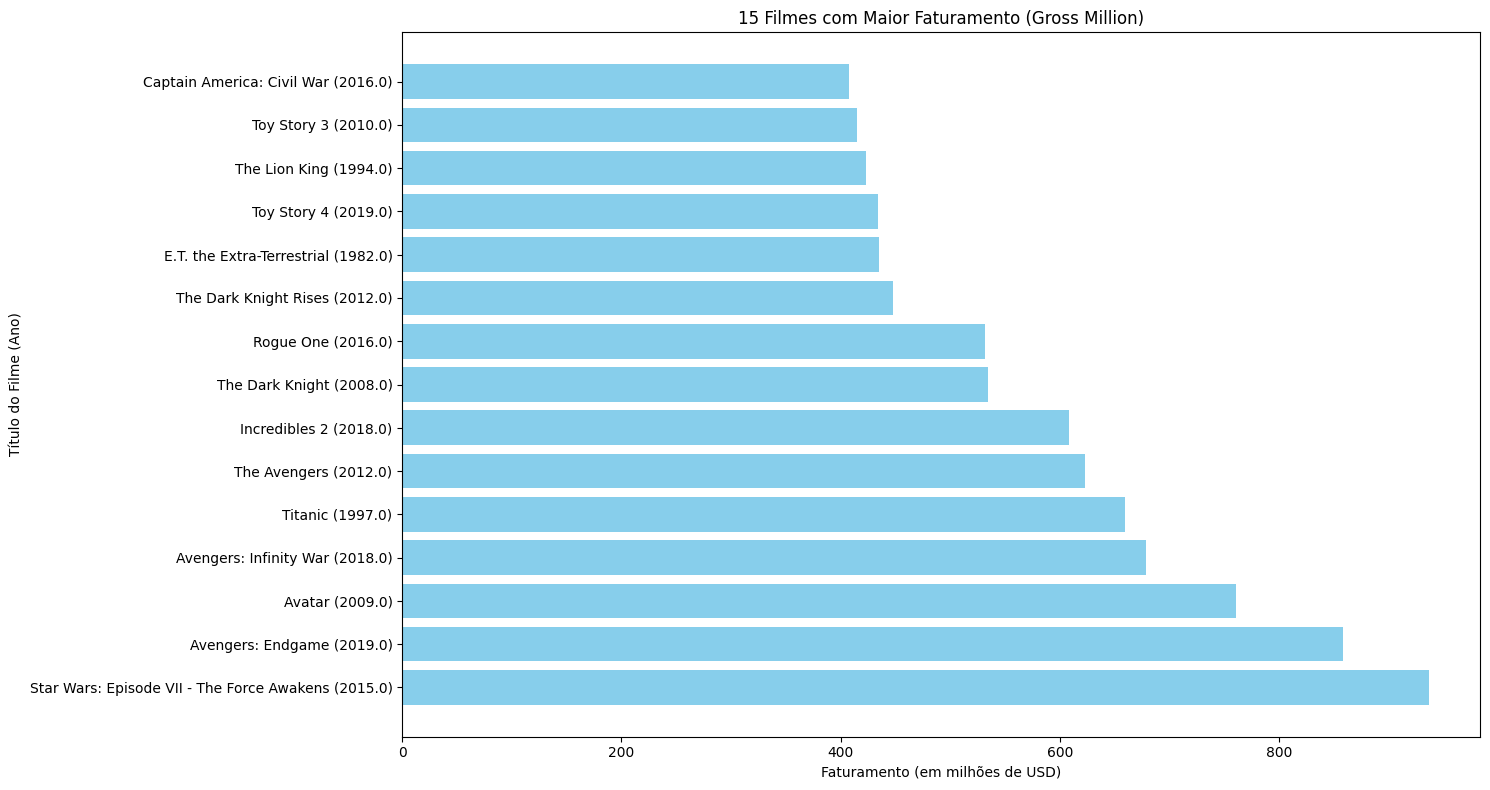

In [591]:
# Apêndice

# Histograma de Meta_score
plt.figure(figsize=(8,4))
sns.histplot(df['Meta_score'], bins=20, kde=True)
plt.title('Distribuição de Meta_score')
plt.xlabel('Meta_score')
plt.ylabel('Frequência')
plt.show()

# Distribuição de Runtime
plt.figure(figsize=(8,4))
sns.histplot(df['Runtime'], bins=20, kde=True)
plt.title('Distribuição de Runtime')
plt.xlabel('Runtime (min)')
plt.ylabel('Frequência')
plt.show()

# Histograma do Número de votos
plt.figure(figsize=(8,4))
sns.histplot(df['No_of_Votes'], bins=20, kde=True)
plt.title('Distribuição de No_of_Votes')
plt.xlabel('No_of_Votes')
plt.ylabel('Frequência')
plt.show()

# Contagem por gênero primário
plt.figure(figsize=(12,6))
sns.countplot(data=df, y='Primary_Genre', order=df['Primary_Genre'].value_counts().index, palette='pastel')
plt.title('Contagem por Primary_Genre')
plt.xlabel('Contagem')
plt.ylabel('Primary_Genre')
plt.show()

# Contagem por classificação etária
plt.figure(figsize=(8,5))
sns.countplot(data=df, y='Certificate', order=df['Certificate'].value_counts().index, palette='pastel')
plt.title('Contagem por Certificate')
plt.xlabel('Contagem')
plt.ylabel('Certificate')
plt.show()

# Diretores com mais filmes
top_dirs = df['Director'].value_counts().head(20).index
plt.figure(figsize=(12,8))
sns.countplot(data=df[df['Director'].isin(top_dirs)], y='Director', order=top_dirs, palette='pastel')
plt.title('Contagem de Filmes por Diretor (Top 20)')
plt.xlabel('Contagem')
plt.ylabel('Director')
plt.show()

# Gráfico de atores com mais filmes como etrela principal (Star1)
# 1. Contar a frequência dos atores e pegar os 10 primeiros
contagem_star1 = df['Star1'].value_counts().head(10)

# 2. Criar o gráfico de barras
plt.figure(figsize=(12, 7)) # Define o tamanho da figura
contagem_star1.plot(kind='bar')

# 3. Adicionar títulos e rótulos
plt.title('Top 10 Atores (Star1) por Número de Filmes')
plt.xlabel('Ator/Atriz')
plt.ylabel('Número de Filmes')
plt.xticks(rotation=45, ha='right') # Rotaciona os nomes para melhor visualização
plt.tight_layout() # Ajusta o layout para evitar que os rótulos se sobreponham
plt.show()

# Relação numérica entre as variáveis
corr_df = df[['IMDB_Rating','Meta_score','No_of_Votes','Gross_Million', 'Budget']]
sns.heatmap(corr_df.corr(min_periods=1), annot=True, cmap="coolwarm")
plt.title('Correlação entre variáveis numéricas')
plt.show()

# Ordenar o DataFrame pelo faturamento em ordem decrescente e selecionar os 15 primeiros
# Assumindo que a coluna de faturamento em milhões é a 'Gross_Million'
# Para barras horizontais, é melhor ordenar ascending=True para que o maior valor fique no topo
df_top_gross = df.nlargest(15, 'Gross_Million').sort_values('Gross_Million', ascending=True).copy()

# Criar um novo rótulo combinando o título do filme e o ano
df_top_gross['Title_Year'] = df_top_gross['Series_Title'] + ' (' + df_top_gross['Released_Year'].astype(str) + ')'

# Criar o gráfico de barras horizontais
plt.figure(figsize=(15, 8))
plt.barh(df_top_gross['Title_Year'], df_top_gross['Gross_Million'], color='skyblue')

# Adicionar títulos e rótulos
plt.title('15 Filmes com Maior Faturamento (Gross Million)')
plt.ylabel('Título do Filme (Ano)')
plt.xlabel('Faturamento (em milhões de USD)')

# Inverter o eixo Y para que o filme com maior faturamento apareça no topo
plt.gca().invert_yaxis()

plt.tight_layout()

# Exibir o gráfico
plt.show()



C:\Users\Technook\AppData\Local\Temp\ipykernel_20048\3382814121.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Primary_Genre', y='Gross_Million', palette='Blues_r')


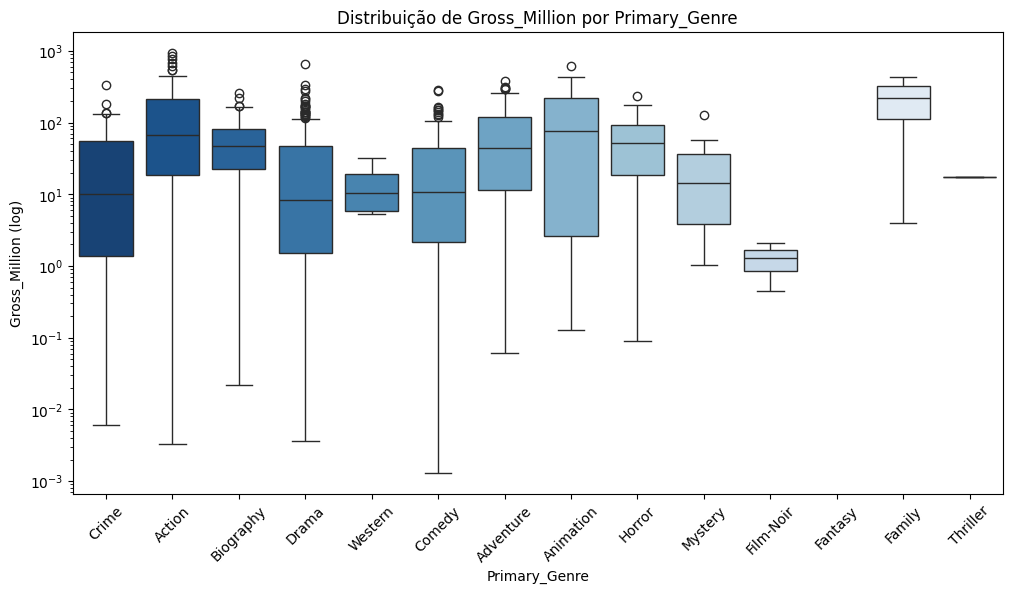

In [592]:
# Apêndice 2
# Distribuição do faturamento por gênero principal
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='Primary_Genre', y='Gross_Million', palette='Blues_r')
plt.yscale('log')
plt.xticks(rotation=45)
plt.title('Distribuição de Gross_Million por Primary_Genre')
plt.xlabel('Primary_Genre')
plt.ylabel('Gross_Million (log)')
plt.show()



O faturamento apresenta grande variação para cada gênero, com muitos outliers puxando os valores para cima. Gêneros como Animation (Animação), Action (Ação) e Family (Família) aparecem com medianas mais altas, enquanto outros, como Drama (Drama) e Western (Faroeste), tem valores menores.

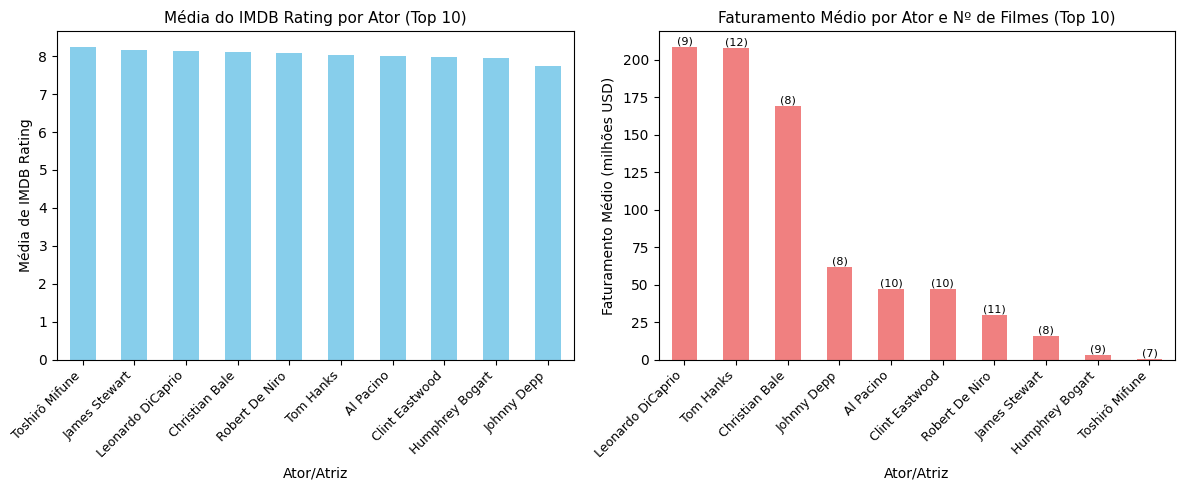

In [593]:
# Apêndice 3

# Comparação entre a média de IMDB Rating e o faturamento médio dos 10 atores com mais filmes como protagonistas

# Top 10 atores mais frequentes
top_10_actors = df['Star1'].value_counts().head(10).index.tolist()
df_top_10 = df[df['Star1'].isin(top_10_actors)]

# Calcular métricas
avg_imdb_rating = df_top_10.groupby('Star1')['IMDB_Rating'].mean().sort_values(ascending=False)
avg_gross_million = df_top_10.groupby('Star1')['Gross_Million'].mean().sort_values(ascending=False)

# Contagem de filmes por ator, na ordem do gráfico de faturamento
contagem_filmes = df['Star1'].value_counts().head(10)
contagem_filmes_ordenada = contagem_filmes.loc[avg_gross_million.index]

# Criar figura com subplots lado a lado (reduzida para caber bem)
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# --- Gráfico 1: Média do IMDB Rating ---
avg_imdb_rating.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Média do IMDB Rating por Ator (Top 10)', fontsize=11)
axes[0].set_xlabel('Ator/Atriz', fontsize=10)
axes[0].set_ylabel('Média de IMDB Rating', fontsize=10)
axes[0].set_xticklabels(avg_imdb_rating.index, rotation=45, ha='right', fontsize=9)

# --- Gráfico 2: Faturamento Médio ---
avg_gross_million.plot(kind='bar', ax=axes[1], color='lightcoral')

# Adicionar número de filmes como rótulo em cada barra
for i, (actor, gross_avg) in enumerate(avg_gross_million.items()):
    num_movies = contagem_filmes_ordenada[actor]
    axes[1].text(i, gross_avg + 0.5, f'({num_movies})',
                 ha='center', va='bottom', fontsize=8)

axes[1].set_title('Faturamento Médio por Ator e Nº de Filmes (Top 10)', fontsize=11)
axes[1].set_xlabel('Ator/Atriz', fontsize=10)
axes[1].set_ylabel('Faturamento Médio (milhões USD)', fontsize=10)
axes[1].set_xticklabels(avg_gross_million.index, rotation=45, ha='right', fontsize=9)

plt.tight_layout()
plt.show()


Esses dois gráficos comparam os mesmos 10 atores mais frequentes na base. Nas notas médias do IMDB, todos ficam próximos de 8, sem grandes diferenças. Já no faturamento médio, a disparidade é bem maior: Leonardo DiCaprio, Tom Hanks e Christian Bale aparecem muito acima dos outros. Isso mostra que, mesmo entre os atores mais recorrentes, a avaliação do público é bem parecida, mas o impacto financeiro pode variar bastante.

C:\Users\Technook\AppData\Local\Temp\ipykernel_20048\2295260334.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Technook\AppData\Local\Temp\ipykernel_20048\2295260334.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


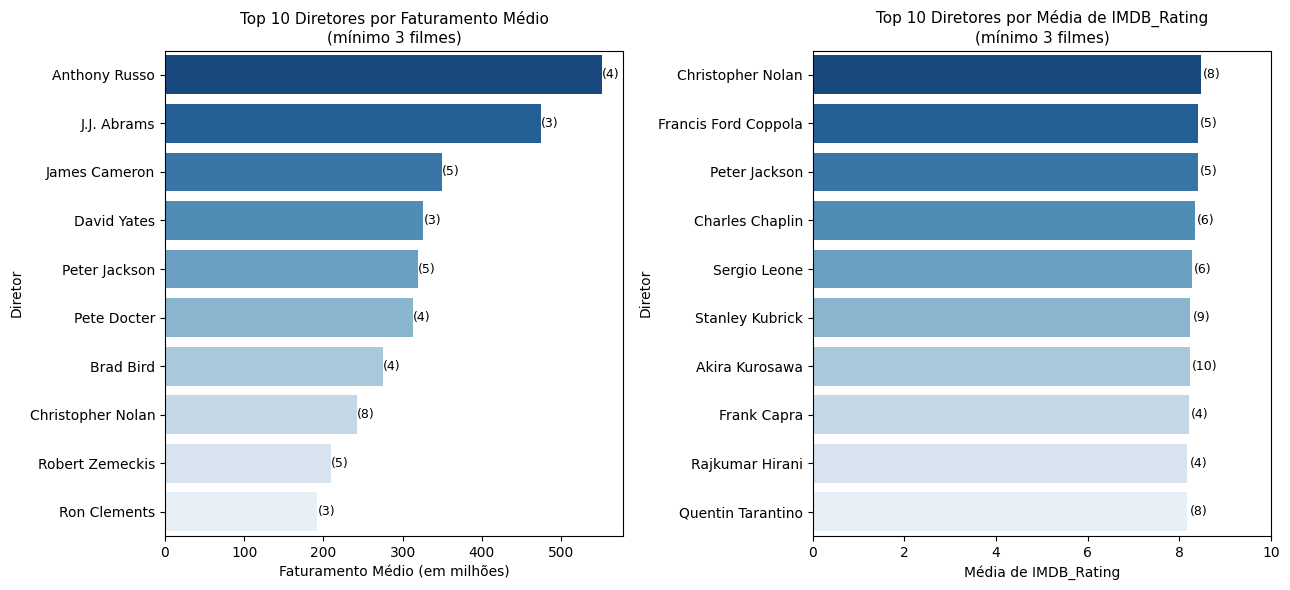

In [594]:
# Apêndice 4

# Comparação: Top 10 Diretores por Faturamento Médio vs Nota Média do IMDB (mínimo 3 filmes)

# --- Parte 1: Faturamento Médio ---
# Contagem de filmes por diretor
contagem_filmes = df['Director'].value_counts()

# Filtrar para manter apenas diretores com 3 ou mais filmes
diretores_com_min_filmes = contagem_filmes[contagem_filmes >= 3].index
df_filtrado_diretores = df[df['Director'].isin(diretores_com_min_filmes)]

# Obter faturamento médio e selecionar top 10
top_directors_gross = (
    df_filtrado_diretores.groupby("Director")["Gross_Million"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

# Alinhar contagem de filmes com os diretores do top 10
contagem_top_diretores = contagem_filmes.loc[top_directors_gross.index]

# --- Parte 2: Nota Média do IMDB ---
directors_stats = (
    df.groupby("Director")
    .agg(
        media_rating=("IMDB_Rating", "mean"),
        qtd_filmes=("IMDB_Rating", "count")
    )
    .reset_index()
)

# Filtrar diretores com pelo menos 3 filmes avaliados
directors_stats = directors_stats[directors_stats["qtd_filmes"] >= 3]

# Selecionar top 10
top_directors_rating = directors_stats.sort_values("media_rating", ascending=False).head(10)

# --- Criar subplots lado a lado ---
fig, axes = plt.subplots(1, 2, figsize=(13,6))

# Gráfico 1: Faturamento Médio
sns.barplot(
    x=top_directors_gross.values,
    y=top_directors_gross.index,
    palette="Blues_r",
    ax=axes[0]
)
axes[0].set_title("Top 10 Diretores por Faturamento Médio\n(mínimo 3 filmes)", fontsize=11)
axes[0].set_xlabel("Faturamento Médio (em milhões)")
axes[0].set_ylabel("Diretor")

# Adicionar número de filmes
for i, (director, gross_avg) in enumerate(top_directors_gross.items()):
    num_movies = contagem_top_diretores[director]
    axes[0].text(gross_avg + 0.2, i, f'({num_movies})', va='center', fontsize=9)

# Gráfico 2: Média de IMDB Rating
sns.barplot(
    x=top_directors_rating["media_rating"],
    y=top_directors_rating["Director"],
    palette="Blues_r",
    ax=axes[1]
)
axes[1].set_title("Top 10 Diretores por Média de IMDB_Rating\n(mínimo 3 filmes)", fontsize=11)
axes[1].set_xlabel("Média de IMDB_Rating")
axes[1].set_ylabel("Diretor")
axes[1].set_xlim(0, 10)

# Adicionar nº de filmes
for i, (media, qtd) in enumerate(zip(top_directors_rating["media_rating"], top_directors_rating["qtd_filmes"])):
    axes[1].text(media + 0.05, i, f"({qtd})", va='center', fontsize=9)

plt.tight_layout()
plt.show()


Esses dois gráficos comparam os 10 diretores com as melhores notas do público e os maiores faturamentos (considerando apenas quem tem pelo menos 3 filmes na base). No faturamento médio, aparecem nomes ligados a grandes franquias, como Anthony Russo, J.J. Abrams e James Cameron, todos acima de 300 milhões de dólares. Já no ranking de nota média do IMDB, predominam diretores clássicos como Christopher Nolan, Stanley Kubrick, Akira Kurosawa e Quentin Tarantino, todos com médias acima de 8. Isso mostra que sucesso financeiro e prestígio crítico do público não caminham juntos, já que só Christopher Nolan e Peter Jackson aparecem nos dois Top 10. Essa diferença confirma a relação quase inexistente entre faturamento médio e nota do IMDB (≈0,09), agora também visível no recorte dos principais diretores.

C:\Users\Technook\AppData\Local\Temp\ipykernel_20048\1296072085.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


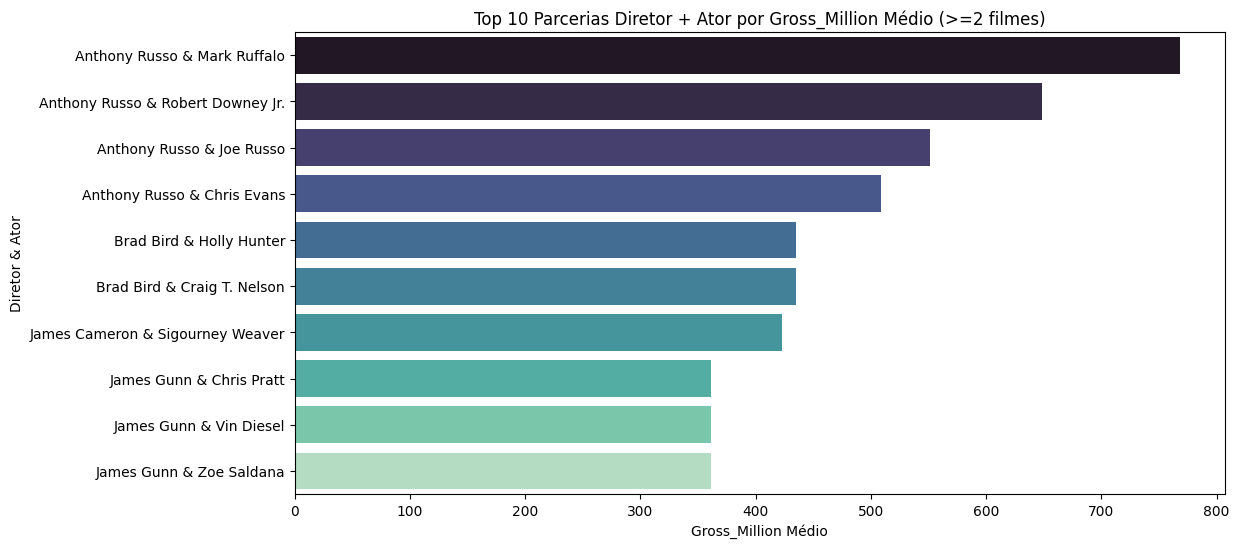

In [595]:
# Apêndice 5

# Transformar os 4 atores em um formato "long"
df_long = pd.melt(
    df,
    id_vars=['Director', 'Gross_Million'],  # colunas que ficam fixas
    value_vars=['Star1', 'Star2', 'Star3', 'Star4'],  # colunas que serão empilhadas
    var_name='Star_Pos',  # opcional, indica a posição do ator
    value_name='Actor'    # nome da nova coluna com os atores
)

# Agrupar por Diretor + Ator
dir_actor_gross = (
    df_long.groupby(['Director', 'Actor'])['Gross_Million']
    .agg(['mean', 'count'])
    .reset_index()
)

# Filtrar apenas parcerias com pelo menos 2 filmes
dir_actor_gross = dir_actor_gross[dir_actor_gross['count'] >= 2]

# Selecionar top 10 por média de Gross
top_dir_actor_gross = dir_actor_gross.sort_values('mean', ascending=False).head(10)

# Concatenar nome Diretor + Ator
top_dir_actor_gross['Parceria'] = (
    top_dir_actor_gross['Director'] + " & " + top_dir_actor_gross['Actor']
)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(
    data=top_dir_actor_gross,
    x='mean', y='Parceria',
    palette='mako'
)
plt.title('Top 10 Parcerias Diretor + Ator por Gross_Million Médio (>=2 filmes)')
plt.xlabel('Gross_Million Médio')
plt.ylabel('Diretor & Ator')
plt.show()


C:\Users\Technook\AppData\Local\Temp\ipykernel_20048\327985786.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax0.set_xticklabels(ax0.get_xticklabels(), rotation=45, ha='right')


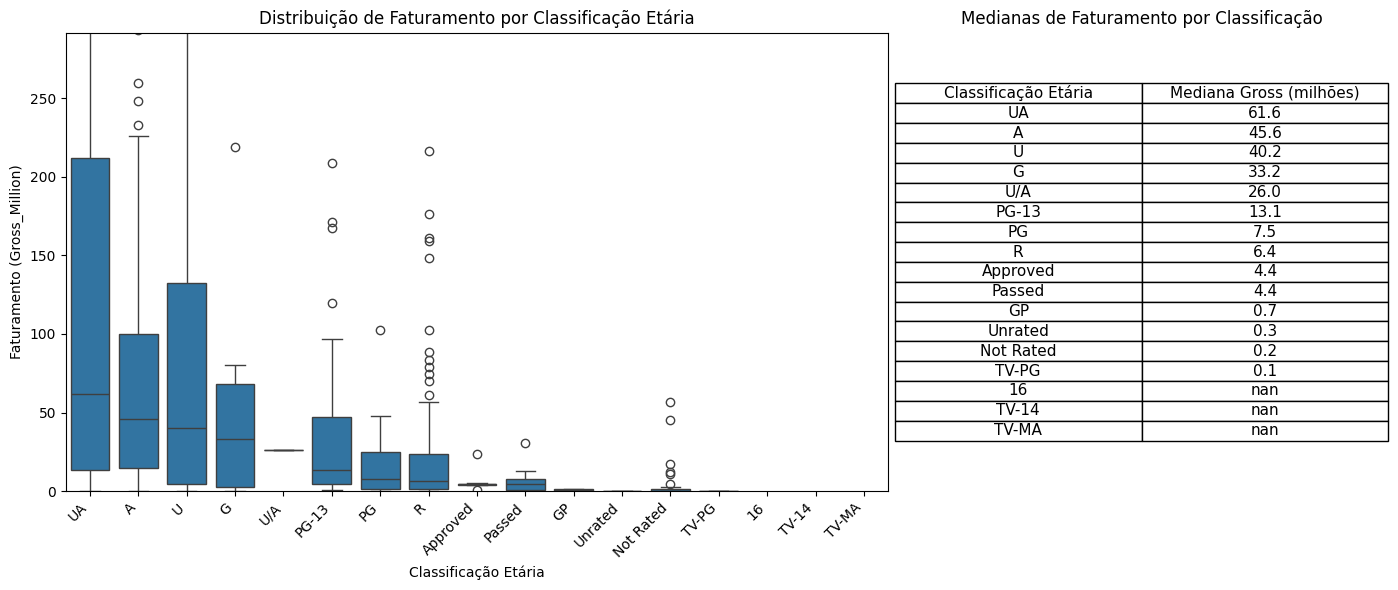


Kruskal-Wallis p-value (Certificate vs Gross): 3.7518336557628696e-35


In [596]:

# Faturamento por classificação etária (Certificate)
# =====================
if 'Certificate_clean' in df.columns:   # usa df direto
    # Calcular medianas
    cert_medians = (
        df.groupby('Certificate_clean')['Gross_Million']
        .median()
        .sort_values(ascending=False)
    )

    # Criar figura lado a lado
    fig = plt.figure(figsize=(14,6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])

    # Boxplot (esquerda)
    ax0 = fig.add_subplot(gs[0])
    sns.boxplot(
        x='Certificate_clean',
        y='Gross_Million',
        data=df,
        order=cert_medians.index,
        ax=ax0
    )
    ax0.set_xticklabels(ax0.get_xticklabels(), rotation=45, ha='right')
    ax0.set_ylim(0, df['Gross_Million'].quantile(0.95))
    ax0.set_title('Distribuição de Faturamento por Classificação Etária')
    ax0.set_xlabel("Classificação Etária")
    ax0.set_ylabel("Faturamento (Gross_Million)")

    # Tabela (direita)
    ax1 = fig.add_subplot(gs[1])
    ax1.axis("off")
    # formatando valores para 1 casa decimal
    cell_data = cert_medians.reset_index()
    cell_data['Gross_Million'] = cell_data['Gross_Million'].map(lambda x: f"{x:,.1f}")
    tbl = ax1.table(
        cellText=cell_data.values,
        colLabels=["Classificação Etária", "Mediana Gross (milhões)"],
        cellLoc="center", loc="center"
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(11)
    tbl.scale(1.2, 1.2)
    ax1.set_title("Medianas de Faturamento por Classificação")

    plt.tight_layout()
    plt.show()

    # Teste estatístico Kruskal-Wallis
    groups = [g['Gross_Million'].dropna().values for _, g in df.groupby('Certificate_clean')]
    cert_p = stats.kruskal(*[g for g in groups if len(g)>0]).pvalue
    print("\nKruskal-Wallis p-value (Certificate vs Gross):", cert_p)
    plt.show()




O boxplot confirma que as classificações mais livres (UA, A, U e G) tem as maiores medianas de faturamento, enquanto faixas etárias mais restritivas (PG-13, PG, R) apresentam valores medianos bem menores. Isso reforça que filmes voltados a públicos mais amplos tendem a ter maior alcance de bilheteria, enquanto os mais restritos tem um pior retorno financeiro.

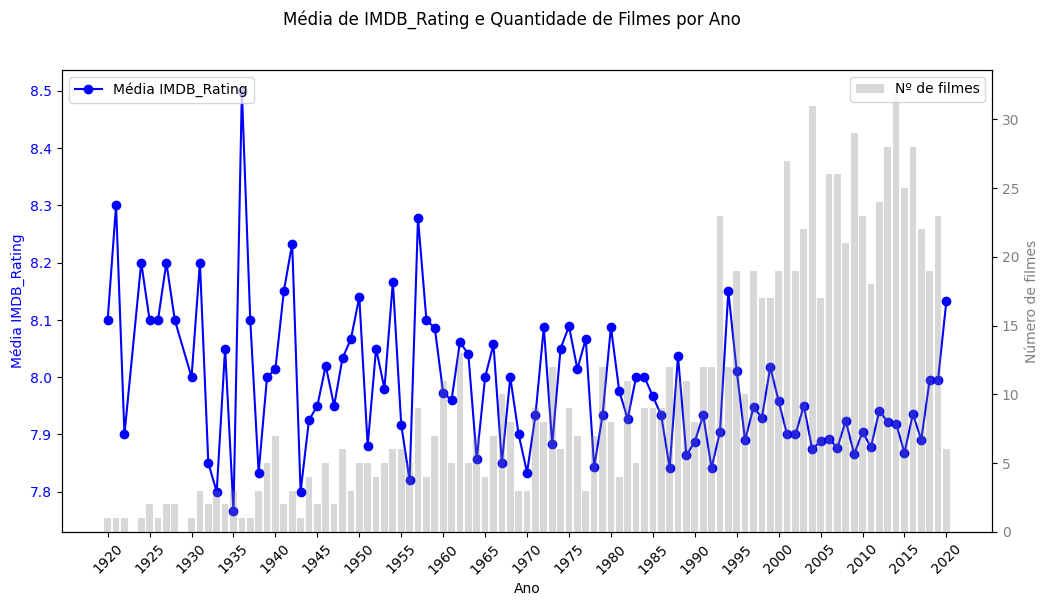

C:\Users\Technook\AppData\Local\Temp\ipykernel_20048\3786526771.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_directors_rating.values, y=top_directors_rating.index, palette='Blues_r')


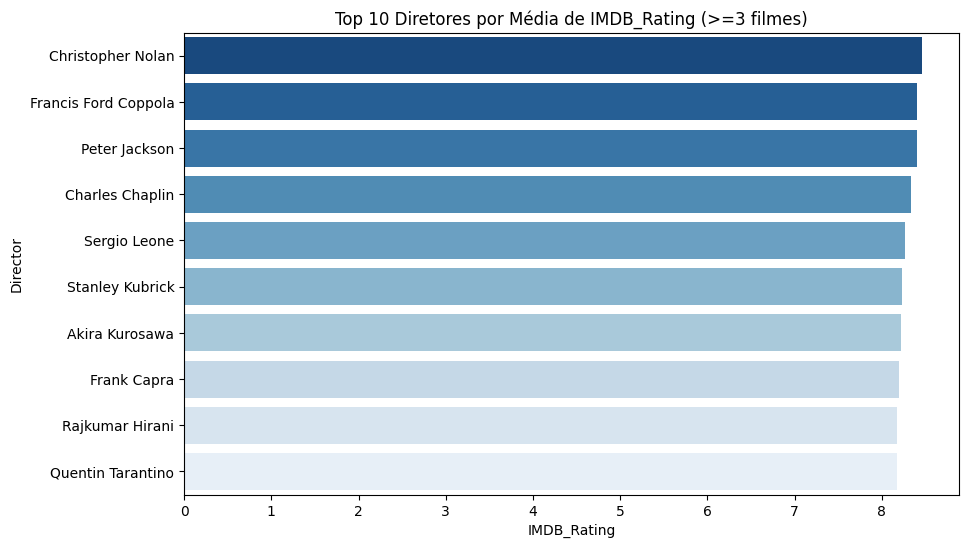

C:\Users\Technook\AppData\Local\Temp\ipykernel_20048\3786526771.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10_rating['IMDB_Rating'], y=top10_rating.index, palette='magma')


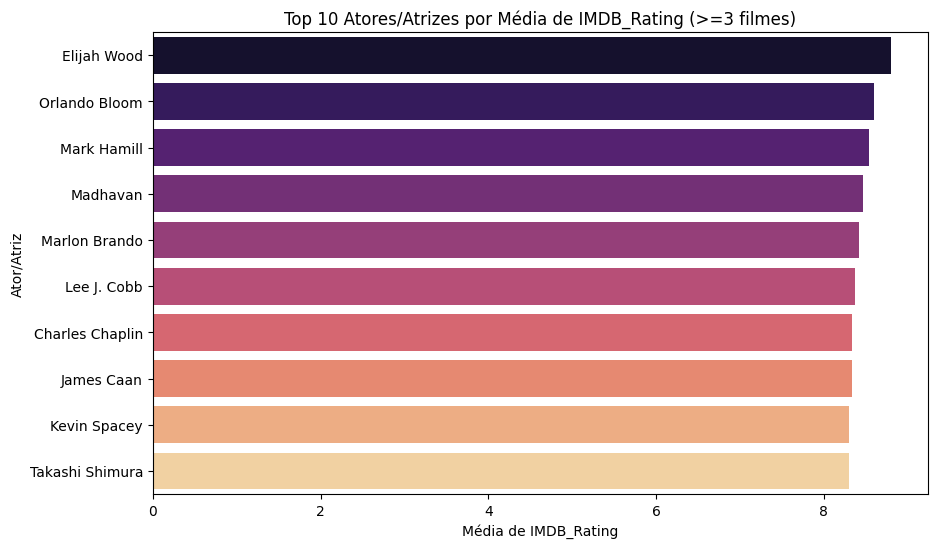

C:\Users\Technook\AppData\Local\Temp\ipykernel_20048\3786526771.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_dir_actor_rating, x='mean', y='Parceria', palette='viridis')


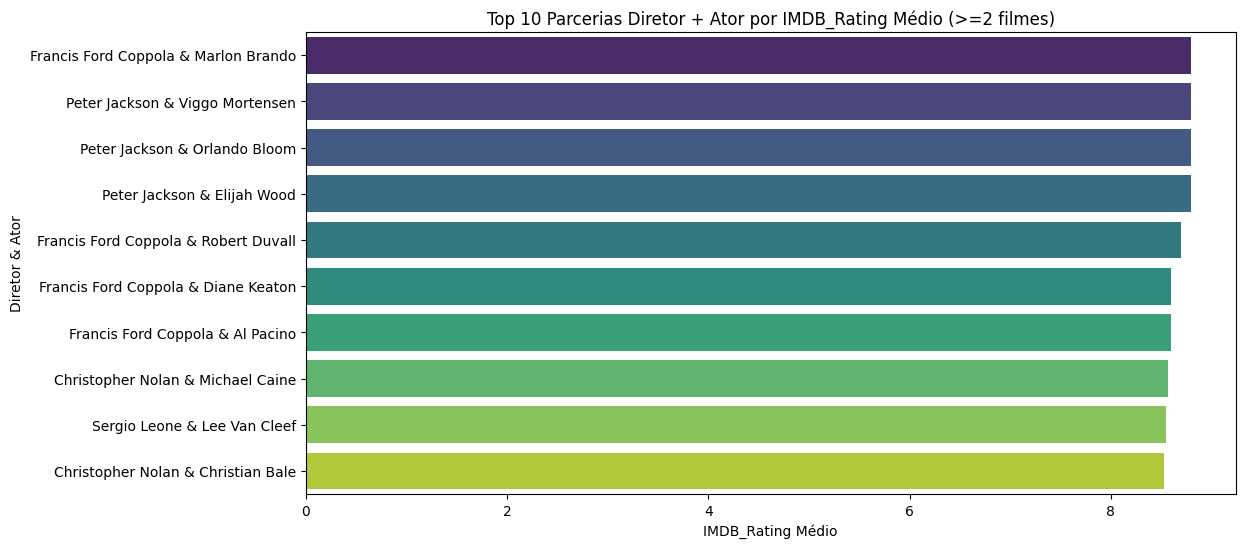

In [597]:
# APENDICE DO IMDB

rating_mean_year = df.groupby('Ano')['IMDB_Rating'].mean()
film_count_year = df.groupby('Ano')['Series_Title'].count()

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(rating_mean_year.index, rating_mean_year.values, color='blue', marker='o', label='Média IMDB_Rating')
ax1.set_xlabel('Ano')
ax1.set_ylabel('Média IMDB_Rating', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(range(rating_mean_year.index.min(), rating_mean_year.index.max()+1, 5))
ax1.set_xticklabels(range(rating_mean_year.index.min(), rating_mean_year.index.max()+1, 5), rotation=45)

ax2 = ax1.twinx()
ax2.bar(film_count_year.index, film_count_year.values, alpha=0.3, color='gray', label='Nº de filmes', width=0.8)
ax2.set_ylabel('Número de filmes', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

fig.suptitle('Média de IMDB_Rating e Quantidade de Filmes por Ano')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

# Top 10 diretores de média da nota do IMDB
# Filtra diretores com pelo menos 3 filmes
director_counts = df['Director'].value_counts()
directors_3plus = director_counts[director_counts>=3].index
top_directors_rating = df[df['Director'].isin(directors_3plus)].groupby('Director')['IMDB_Rating'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_directors_rating.values, y=top_directors_rating.index, palette='Blues_r')
plt.title('Top 10 Diretores por Média de IMDB_Rating (>=3 filmes)')
plt.xlabel('IMDB_Rating')
plt.ylabel('Director')
plt.show()

# Top 10 atores/atrizes por nota do IMDB
# Criar df_melted temporário (não altera o df original)
df_melted = df.melt(
    id_vars=['Series_Title', 'IMDB_Rating'],
    value_vars=['Star1','Star2','Star3','Star4'],
    var_name='Star_Position',
    value_name='Actor'
)

# Calcular média do IMDB_Rating e número de filmes por ator
actor_rating = (
    df_melted.groupby('Actor')
    .agg(
        IMDB_Rating=('IMDB_Rating','mean'),
        Film_Count=('IMDB_Rating','count')
    )
)

# Filtrar atores com pelo menos 3 filmes
actor_rating = actor_rating[actor_rating['Film_Count'] >= 3]

# Selecionar top 10
top10_rating = actor_rating.sort_values('IMDB_Rating', ascending=False).head(10)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=top10_rating['IMDB_Rating'], y=top10_rating.index, palette='magma')
plt.title('Top 10 Atores/Atrizes por Média de IMDB_Rating (>=3 filmes)')
plt.xlabel('Média de IMDB_Rating')
plt.ylabel('Ator/Atriz')
plt.show()

# Transformar Star1–4 em uma única coluna de atores
df_long = df.melt(id_vars=['Director', 'IMDB_Rating', 'Gross_Million'],
                  value_vars=['Star1', 'Star2', 'Star3', 'Star4'],
                  var_name='StarPos', value_name='Actor')

# Agrupar por Diretor + Ator
dir_actor_rating = (
    df_long.groupby(['Director', 'Actor'])['IMDB_Rating']
    .agg(['mean', 'count'])
    .reset_index()
)

# Filtrar apenas parcerias com pelo menos 2 filmes
dir_actor_rating = dir_actor_rating[dir_actor_rating['count'] >= 2]

# Selecionar top 10 por média de IMDB
top_dir_actor_rating = dir_actor_rating.sort_values('mean', ascending=False).head(10)

# Concatenar nome Diretor + Ator
top_dir_actor_rating['Parceria'] = top_dir_actor_rating['Director'] + " & " + top_dir_actor_rating['Actor']

# Plot
plt.figure(figsize=(12,6))
sns.barplot(data=top_dir_actor_rating, x='mean', y='Parceria', palette='viridis')
plt.title('Top 10 Parcerias Diretor + Ator por IMDB_Rating Médio (>=2 filmes)')
plt.xlabel('IMDB_Rating Médio')
plt.ylabel('Diretor & Ator')
plt.show()




# 3)
Tratei como regressão (nota 0–10), pois a nota é uma variável contínua. Usei o que mais ajuda a explicar a nota: número de votos, meta score, duração e a sinopse (Overview).Escolhi número de votos porque é o que tem correlação mais forte com a nota, meta score porque apesar de ter pouca relação, ainda é a segunda maior dentre as variáveis numéricas e duração porque a maioria dos filmes com boas notas tem entre 90 e 150 minutos, mesmo as variáveis tendo uma correlação muito fraca. Incluí também gênero principal, classificação etária, diretor e principais atores para capturar o perfil do filme. Ano e faturamento entraram como apoio. Budget ficou de fora por ter muitos dados ausentes e não compensar o risco de uma tentativa de estimar medidas (já que as 2 variáveis tem correlação quase zero).

Pré-processamento:
Nos números: preenchi faltas com mediana, apliquei log em votos/faturamento e padronizei.
Nas categóricas: transformei em indicadores 0/1 (agrupando nomes muito raros).
Na sinopse: converti o texto em números destacando palavras mais importantes (TF-IDF).

Modelos e escolha.
Testei um modelo linear (Ridge) e um de árvores em conjunto (HistGradientBoosting). Escolhi pelo menor MAE usando validação cruzada no treino e depois confirmei no conjunto de teste (20%).
Escolhi MAE como métrica principal porque é simples de entender: mostra o erro médio direto na escala do IMDB. No meu teste, deu MAE = 0,158 (≈0,16 ponto). Como apoio, também reportei RMSE = 0,201 e R² = 0,457, mas a decisão foi guiada pelo MAE.

Resultado final (teste).
Vencedor: Ridge.
MAE = 0.158 (erro médio de ~0,16 ponto na nota), RMSE = 0.201, R² = 0.457 (explica ~46% da variação).

Modelo que melhor se aproxima dos dados: Ridge (linear).Pois, no meu teste foi o que entregou o menor erro (MAE = 0,158, RMSE = 0,201, R² = 0,457).
Prós do Ridge: simples e estável, rápido de treinar, lida muito bem com o texto vetorizado (TF-IDF) e evita exageros nos coeficientes.
Contras: por ser linear, não capta relações mais complexas ou  que não sejam lineares entre as variáveis.

Escolhi MAE como métrica principal porque é simples de entender: mostra o erro médio direto na escala do IMDB. No meu teste, deu MAE = 0,158 (≈0,16 ponto). Como apoio, também reportei RMSE = 0,201 e R² = 0,457, mas a decisão foi guiada pelo MAE.

Preparando o Dataset

In [598]:
# Modelagem (Q3) — separado treino e teste
# =========================
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# --------- helpers ---------
def parse_runtime_to_min(x):
    if pd.isna(x): return np.nan
    m = re.search(r"(\d+)", str(x))
    return float(m.group(1)) if m else np.nan

def parse_gross_to_usd(x):
    if pd.isna(x): return np.nan
    s = re.sub(r"[^\d]", "", str(x))
    return float(s) if s else np.nan

def build_features(df):
    d = df.copy()
    if "Runtime" in d: d["Runtime_min"] = d["Runtime"].apply(parse_runtime_to_min)
    if "Gross" in d:   d["Gross_USD"]   = d["Gross"].apply(parse_gross_to_usd)
    if "Released_Year" in d: d["Released_Year"] = pd.to_numeric(d["Released_Year"], errors="coerce")
    if "Genre" in d:
        d["Primary_Genre"] = d["Genre"].fillna("").apply(lambda x: str(x).split(",")[0].strip() if x else np.nan)
    if "No_of_Votes" in d: d["log_votes"] = np.log1p(d["No_of_Votes"])
    if "Gross_USD" in d:   d["log_gross"] = np.log1p(d["Gross_USD"])
    return d

# --------- dados (usa seu df já carregado) ---------
assert "df" in globals(), "Carregue seu DataFrame original como `df` antes de rodar esta célula."
df_ml = build_features(df).dropna(subset=["IMDB_Rating"]).copy()
y = df_ml["IMDB_Rating"].astype(float)

# colunas usadas (sem Budget)
num_cols = [c for c in ["Runtime_min","Meta_score","No_of_Votes","Gross_USD","Released_Year","log_votes","log_gross"] if c in df_ml]
cat_cols = [c for c in ["Certificate","Primary_Genre","Director","Star1","Star2","Star3","Star4"] if c in df_ml]
text_col = "Overview" if "Overview" in df_ml.columns else None

X = df_ml.drop(columns=["IMDB_Rating"])
for col in ["Budget","Budget_USD"]:
    if col in X.columns:
        X = X.drop(columns=[col])  # Budget fora do modelo

# --------- split treino/teste (20%) com estratificação por faixas da nota ---------
y_bins = pd.qcut(y, q=10, duplicates="drop")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y_bins, random_state=RANDOM_STATE
)

# --------- Modelo 1: Ridge (linear) com normalização ---------
ridge_transformers = [
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=False))  # normaliza numéricas
    ]), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)  # sem min_frequency p/ compatibilidade
]
if text_col:
    ridge_transformers.append(
        ("txt", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=10000, stop_words="english"), text_col)
    )

preprocess_ridge = ColumnTransformer(transformers=ridge_transformers, remainder="drop")
ridge_pipe = Pipeline([("prep", preprocess_ridge), ("model", Ridge())])
ridge_grid = {"model__alpha": [0.3, 1.0, 3.0]}
ridge_cv = GridSearchCV(ridge_pipe, ridge_grid, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1)
ridge_cv.fit(X_train, y_train)
ridge_best = ridge_cv.best_estimator_
ridge_cv_mae = -ridge_cv.best_score_

# --------- Modelo 2: HistGradientBoosting (árvores) ---------
# OneHotEncoder compatível com qualquer versão

cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)


hgb_transformers = [
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())  # normaliza numéricas (opcional p/ árvores)
    ]), num_cols),
    ("cat", cat_encoder, cat_cols)
]
if text_col:
    hgb_transformers.append(
        ("txt", Pipeline([
            ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=3, max_features=5000, stop_words="english")),
            ("svd", TruncatedSVD(n_components=150, random_state=RANDOM_STATE))
        ]), text_col)
    )

preprocess_hgb = ColumnTransformer(transformers=hgb_transformers, remainder="drop", sparse_threshold=0.0)
hgb_pipe = Pipeline([("prep", preprocess_hgb), ("model", HistGradientBoostingRegressor(random_state=RANDOM_STATE))])
hgb_grid = {"model__learning_rate": [0.05, 0.1], "model__max_depth": [None, 8]}
hgb_cv = GridSearchCV(hgb_pipe, hgb_grid, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1)
hgb_cv.fit(X_train, y_train)
hgb_best = hgb_cv.best_estimator_
hgb_cv_mae = -hgb_cv.best_score_

# --------- escolher vencedor pelo MAE do CV no treino ---------
if hgb_cv_mae < ridge_cv_mae:
    best_name, best_model = "HistGradientBoosting", hgb_best
else:
    best_name, best_model = "Ridge", ridge_best

# --------- avaliação no TESTE ---------
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # compatível com versões antigas
r2 = r2_score(y_test, y_pred)

print(f"Modelo vencedor (pelo CV no treino): {best_name}")
print(f"Teste — MAE:  {mae:.3f}")
print(f"Teste — RMSE: {rmse:.3f}")
print(f"Teste — R²:   {r2:.3f}")

# --------- treino final em todos os dados e salvar .pkl ---------
final_model = best_model.fit(X, y)
joblib.dump(final_model, "../models/model_imdb_pipeline.pkl")
print("Arquivo salvo: model_imdb_pipeline.pkl (pipeline completo, pronto para usar)")

Modelo vencedor (pelo CV no treino): Ridge
Teste — MAE:  0.160
Teste — RMSE: 0.203
Teste — R²:   0.450
Arquivo salvo: model_imdb_pipeline.pkl (pipeline completo, pronto para usar)


4)

In [ ]:

# carregar modelo treinado
model = joblib.load("../models/model_imdb_pipeline.pkl")

# filme de exemplo
novo_filme = {
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': '1994',
    'Certificate': 'A',
    'Runtime': '142 min',
    'Genre': 'Drama',
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': '28,341,469'
}

# criar dataframe com uma linha
df_novo = pd.DataFrame([novo_filme])

# aplicar as mesmas transformações que no treino
from copy import deepcopy
from __main__ import build_features  # garante que usa a mesma função definida antes

df_novo_proc = build_features(df_novo)

# prever nota
pred = model.predict(df_novo_proc)[0]
print(f"Previsão de IMDB_Rating para '{novo_filme['Series_Title']}': {pred:.2f}")


Previsão de IMDB_Rating para 'The Shawshank Redemption': 9.62
Teste 'The Shawshank Redemption': 9.62


# 4. 
A nota do filme seria 9.63 de acordo com meu modelo vencedor.